In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from typing import Tuple, Optional

class LQR:
    def __init__(self, H: torch.Tensor, M: torch.Tensor, sigma: torch.Tensor, 
                 C: torch.Tensor, D: torch.Tensor, R: torch.Tensor, 
                 T: float, time_grid: torch.Tensor):
        """
        Initialize the LQR problem.
        
        Args:
            H: System dynamics matrix (d x d)
            M: Control input matrix (d x m)
            sigma: Noise matrix (d x d')
            C: State cost matrix (d x d)
            D: Control cost matrix (m x m)
            R: Terminal state cost matrix (d x d)
            T: Terminal time
            time_grid: Grid of time points
        """
        self.H = H
        self.M = M
        self.sigma = sigma
        self.C = C
        self.D = D
        self.R = R
        self.T = T
        self.time_grid = time_grid
        
        # Check dimensions
        d, m = M.shape
        assert H.shape == (d, d), "H must be d x d"
        assert sigma.shape[0] == d, "sigma must be d x d'"
        assert C.shape == (d, d), "C must be d x d"
        assert D.shape == (m, m), "D must be m x m"
        assert R.shape == (d, d), "R must be d x d"
        
        # Store dimensions
        self.d = d
        self.m = m
        
        # Compute inverse of D once for efficiency
        self.D_inv = torch.inverse(D)
        
        # Initialize solution placeholders
        self.S_grid = None  # Will be populated when solve_ricatti is called
        self.int_term_grid = None  # Will store the integral term
        
    def ricatti_rhs(self, t: float, S_flat: np.ndarray) -> np.ndarray:
        """
        Right-hand side of the Ricatti ODE: S'(t) = S(t)MD^(-1)M^TS(t) - H^TS(t) - S(t)H - C
        
        Args:
            t: Time
            S_flat: Flattened S matrix
            
        Returns:
            Flattened derivative of S
        """
        # Reshape S from flattened form
        S = torch.tensor(S_flat.reshape(self.d, self.d), dtype=torch.float64)
        
        # Compute right-hand side
        term1 = S @ self.M @ self.D_inv @ self.M.T @ S
        term2 = self.H.T @ S
        term3 = S @ self.H
        term4 = self.C
        
        # Compute derivative
        dS = term1 - term2 - term3 - term4
        
        # Return flattened result
        return dS.flatten().numpy()
    
    def solve_ricatti(self) -> None:
        """
        Solve the Ricatti ODE using scipy's solve_ivp for high accuracy.
        """
        # Convert matrices to double precision if they aren't already
        self.H = self.H.to(torch.float64)
        self.M = self.M.to(torch.float64)
        self.sigma = self.sigma.to(torch.float64)
        self.C = self.C.to(torch.float64)
        self.D = self.D.to(torch.float64)
        self.R = self.R.to(torch.float64)
        self.D_inv = self.D_inv.to(torch.float64)
        
        # Terminal condition: S(T) = R
        S_T_flat = self.R.flatten().numpy()
        
        # Time points for ODE solver (reversed for backward integration)
        t_points = self.time_grid.numpy()
        t_reversed = self.T - t_points[::-1]
        
        # Solve the ODE backward in time (from T to 0)
        solution = solve_ivp(
            lambda t, y: -self.ricatti_rhs(self.T - t, y),  # Negative for backward integration
            [0, self.T],
            S_T_flat,
            t_eval=t_reversed,
            method='RK45',
            rtol=1e-11,
            atol=1e-11
        )
        
        # Convert solution back to PyTorch tensors and reshape
        S_values = solution.y.T
        S_matrices = [S.reshape(self.d, self.d) for S in S_values]
        S_matrices.reverse()  # Reverse back to forward time
        
        self.S_grid = torch.tensor(S_matrices, dtype=torch.float64)
        
        # Compute integral term for value function
        self.compute_integral_term()
    
    def compute_integral_term(self) -> None:
        """
        Compute the integral term for the value function: int_t^T tr(sigma sigma^T S(r)) dr
        """
        if self.S_grid is None:
            self.solve_ricatti()
        
        # Compute trace term at each time point
        trace_terms = torch.zeros(len(self.time_grid))
        sigma_sigma_T = self.sigma @ self.sigma.T
        
        for i in range(len(self.time_grid)):
            trace_terms[i] = torch.trace(sigma_sigma_T @ self.S_grid[i])
        
        # Compute integral using trapezoidal rule (backward from T)
        integral_term = torch.zeros(len(self.time_grid))
        
        for i in range(len(self.time_grid) - 1, 0, -1):
            dt = self.time_grid[i] - self.time_grid[i-1]
            integral_term[i-1] = integral_term[i] + 0.5 * (trace_terms[i] + trace_terms[i-1]) * dt
        
        self.int_term_grid = integral_term
    
    def get_S_at_time(self, t: torch.Tensor) -> torch.Tensor:
        """
        Get the S matrix at a given time by finding the nearest time point in the grid.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            S matrices at the specified times (batch x d x d)
        """
        if self.S_grid is None:
            self.solve_ricatti()
            
        # Find indices of nearest time points for each t
        indices = torch.argmin(torch.abs(t.unsqueeze(1) - self.time_grid.unsqueeze(0)), dim=1)
        
        # Get the corresponding S matrices
        return self.S_grid[indices]
    
    def get_integral_term_at_time(self, t: torch.Tensor) -> torch.Tensor:
        """
        Get the integral term at a given time by finding the nearest time point in the grid.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            Integral terms at the specified times (batch)
        """
        if self.int_term_grid is None:
            self.compute_integral_term()
            
        # Find indices of nearest time points for each t
        indices = torch.argmin(torch.abs(t.unsqueeze(1) - self.time_grid.unsqueeze(0)), dim=1)
        
        # Get the corresponding integral terms
        return self.int_term_grid[indices]
    
    def value_function(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the value function v(t, x) = x^T S(t) x + int_t^T tr(sigma sigma^T S(r)) dr
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Value function at (t, x) (batch)
        """
        # Get S matrices at the specified times
        S_matrices = self.get_S_at_time(t)
        
        # Compute quadratic term x^T S(t) x
        batch_size = x.shape[0]
        values = torch.zeros(batch_size, device=x.device)
        
        for i in range(batch_size):
            values[i] = x[i] @ S_matrices[i] @ x[i]
        
        # Add integral term
        values = values + self.get_integral_term_at_time(t)
        
        return values
    
    def optimal_control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the optimal control a(t, x) = -D^(-1)M^TS(t)x
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Optimal control at (t, x) (batch x m)
        """
        # Get S matrices at the specified times
        S_matrices = self.get_S_at_time(t)
        
        # Compute optimal control for each (t, x) pair
        batch_size = x.shape[0]
        controls = torch.zeros((batch_size, self.m), device=x.device)
        
        for i in range(batch_size):
            controls[i] = -self.D_inv @ self.M.T @ S_matrices[i] @ x[i]
        
        return controls
    
# Update the simulation functions to accept fixed noise
def simulate_sde_explicit(lqr: LQR, x0: torch.Tensor, num_steps: int, num_samples: int, 
                         fixed_noise: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Simulate the controlled SDE using the explicit scheme with optional fixed noise.
    
    Args:
        lqr: LQR instance
        x0: Initial state (batch x d)
        num_steps: Number of time steps
        num_samples: Number of Monte Carlo samples
        fixed_noise: Optional fixed Brownian increments for consistent comparisons
        
    Returns:
        Tuple of (trajectory, cost)
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    batch_size = x0.shape[0]
    d = lqr.d
    
    # Ensure all tensors are double precision
    H = lqr.H.to(torch.float64)
    M = lqr.M.to(torch.float64)
    sigma = lqr.sigma.to(torch.float64)
    C = lqr.C.to(torch.float64)
    D = lqr.D.to(torch.float64)
    
    # Initialize trajectories and costs
    X = torch.zeros((num_samples, batch_size, num_steps + 1, d), dtype=torch.float64)
    X[:, :, 0, :] = x0.unsqueeze(0).repeat(num_samples, 1, 1)
    
    costs = torch.zeros((num_samples, batch_size), dtype=torch.float64)
    
    # Generate Brownian increments or use fixed ones
    if fixed_noise is None:
        dW = torch.randn((num_samples, batch_size, num_steps, sigma.shape[1]), 
                        dtype=torch.float64) * np.sqrt(dt)
    else:
        dW = fixed_noise
    
    # Simulate trajectories
    for n in range(num_steps):
        t_n = t_grid[n]
        X_n = X[:, :, n, :]
        
        # Reshape for batch processing
        X_n_flat = X_n.reshape(-1, d)
        t_flat = t_n.repeat(num_samples * batch_size)
        
        # Compute optimal control
        control_flat = lqr.optimal_control(t_flat, X_n_flat).to(torch.float64)
        control = control_flat.reshape(num_samples, batch_size, lqr.m)
        
        # Compute drift and apply update for each sample
        for i in range(num_samples):
            for j in range(batch_size):
                # Compute drift term: HX + Ma
                drift = H @ X_n[i, j] + M @ control[i, j]
                
                # Update state using explicit scheme
                X[i, j, n+1] = X_n[i, j] + drift * dt + sigma @ dW[i, j, n]
                
                # Accumulate running cost
                state_cost = X_n[i, j] @ C @ X_n[i, j]
                control_cost = control[i, j] @ D @ control[i, j]
                costs[i, j] += (state_cost + control_cost) * dt
    
    # Add terminal cost
    X_T = X[:, :, -1, :]
    for i in range(num_samples):
        for j in range(batch_size):
            terminal_cost = X_T[i, j] @ lqr.R @ X_T[i, j]
            costs[i, j] += terminal_cost
    
    return X, costs

def simulate_sde_implicit(lqr: LQR, x0: torch.Tensor, num_steps: int, num_samples: int,
                         fixed_noise: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Simulate the controlled SDE using the implicit scheme with optional fixed noise.
    
    Args:
        lqr: LQR instance
        x0: Initial state (batch x d)
        num_steps: Number of time steps
        num_samples: Number of Monte Carlo samples
        fixed_noise: Optional fixed Brownian increments for consistent comparisons
        
    Returns:
        Tuple of (trajectory, cost)
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    batch_size = x0.shape[0]
    d = lqr.d
    
    # Ensure all tensors are double precision
    H = lqr.H.to(torch.float64)
    M = lqr.M.to(torch.float64)
    sigma = lqr.sigma.to(torch.float64)
    C = lqr.C.to(torch.float64)
    D = lqr.D.to(torch.float64)
    D_inv = lqr.D_inv.to(torch.float64)
    
    # Initialize trajectories and costs
    X = torch.zeros((num_samples, batch_size, num_steps + 1, d), dtype=torch.float64)
    X[:, :, 0, :] = x0.unsqueeze(0).repeat(num_samples, 1, 1)
    
    costs = torch.zeros((num_samples, batch_size), dtype=torch.float64)
    
    # Generate Brownian increments or use fixed ones
    if fixed_noise is None:
        dW = torch.randn((num_samples, batch_size, num_steps, sigma.shape[1]), 
                        dtype=torch.float64) * np.sqrt(dt)
    else:
        dW = fixed_noise
    
    # Identity matrix for linear system
    I = torch.eye(d, dtype=torch.float64)
    
    # Simulate trajectories
    for n in range(num_steps):
        t_n = t_grid[n]
        t_np1 = t_grid[n+1] 
        X_n = X[:, :, n, :]
        
        # Reshape for batch processing for cost calculation
        X_n_flat = X_n.reshape(-1, d)
        t_flat = t_n.repeat(num_samples * batch_size)
        
        # Compute optimal control for cost calculation
        control_flat = lqr.optimal_control(t_flat, X_n_flat).to(torch.float64)
        control = control_flat.reshape(num_samples, batch_size, lqr.m)
        
        # For implicit scheme, we need to solve a linear system for each sample
        S_np1 = lqr.get_S_at_time(torch.tensor([t_np1], dtype=torch.float64))[0].to(torch.float64)
        
        # Construct system matrix: (I - dt*H + dt*M*D^(-1)*M^T*S(t_{n+1}))
        MD_inv_MT = M @ D_inv @ M.T
        A = I - dt * H + dt * MD_inv_MT @ S_np1
        
        for i in range(num_samples):
            for j in range(batch_size):
                # Compute right-hand side: X_n + sigma * dW_n
                b = X_n[i, j] + sigma @ dW[i, j, n]
                
                # Solve the linear system: A * X_{n+1} = b
                X[i, j, n+1] = torch.linalg.solve(A, b)
                
                # Accumulate running cost
                state_cost = X_n[i, j] @ C @ X_n[i, j]
                control_cost = control[i, j] @ D @ control[i, j]
                costs[i, j] += (state_cost + control_cost) * dt
    
    # Add terminal cost
    X_T = X[:, :, -1, :]
    for i in range(num_samples):
        for j in range(batch_size):
            terminal_cost = X_T[i, j] @ lqr.R @ X_T[i, j]
            costs[i, j] += terminal_cost
    
    return X, costs

def run_monte_carlo_tests(lqr: LQR, x0: torch.Tensor, scheme: str = 'explicit') -> None:
    """
    Run Monte Carlo tests for the LQR problem.
    
    Args:
        lqr: LQR instance
        x0: Initial states to test
        scheme: 'explicit' or 'implicit'
    """
    # 1. Test varying time steps with fixed number of samples
    num_samples = 2500 # should be 10k
    time_steps_list = [2**i for i in range(1, 10)] # should be up to 12
    time_step_errors = []
    
    # Compute true value function at t=0, x=x0
    t0 = torch.zeros(x0.shape[0], dtype=torch.float64)
    true_values = lqr.value_function(t0, x0)
    
    print(f"\n--- Testing convergence for {scheme} scheme ---")
    print("Varying time steps...")
    
    for num_steps in time_steps_list:
        print(f"Running with {num_steps} time steps...")
        
        # Run simulation with current parameters
        if scheme == 'explicit':
            _, costs = simulate_sde_explicit(lqr, x0, num_steps, num_samples)
        else:
            _, costs = simulate_sde_implicit(lqr, x0, num_steps, num_samples)
        
        # Compute mean cost
        mean_costs = costs.mean(dim=0)
        
        # Compute error
        error = torch.abs(mean_costs - true_values).mean().item()
        time_step_errors.append(error)
        
        print(f"  Error: {error:.6f}")
    
    # Plot time step convergence
    plt.figure(figsize=(10, 6))
    plt.loglog(time_steps_list, time_step_errors, 'o-', label=f'{scheme.capitalize()} Scheme')
    
    # Add trend line 
    if scheme == 'explicit':
        ref_line = [time_step_errors[0] * (time_steps_list[0] / n) for n in time_steps_list]
        plt.loglog(time_steps_list, ref_line, '--', label='O(1/N)')
    else:
        ref_line = [time_step_errors[0] * (time_steps_list[0] / n)**2 for n in time_steps_list]
        plt.loglog(time_steps_list, ref_line, '--', label='O(1/N²)')
    
    plt.xlabel('Number of Time Steps (N)')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Convergence with Varying Time Steps ({scheme.capitalize()} Scheme)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 2. Test varying number of samples with fixed number of time steps
    num_steps = 2500  # Large number for accuracy should be 10k
    sample_counts = [2 * 4**i for i in range(5)] # should be range(6)
    sample_errors = []
    
    print("\nVarying sample counts...")
    
    for num_samples in sample_counts:
        print(f"Running with {num_samples} samples...")
        
        # Run simulation with current parameters
        if scheme == 'explicit':
            _, costs = simulate_sde_explicit(lqr, x0, num_steps, num_samples)
        else:
            _, costs = simulate_sde_implicit(lqr, x0, num_steps, num_samples)
        
        # Compute mean cost
        mean_costs = costs.mean(dim=0)
        
        # Compute error
        error = torch.abs(mean_costs - true_values).mean().item()
        sample_errors.append(error)
        
        print(f"  Error: {error:.6f}")
    
    # Plot sample count convergence
    plt.figure(figsize=(10, 6))
    plt.loglog(sample_counts, sample_errors, 'o-', label=f'{scheme.capitalize()} Scheme')
    
    # Add trend line (should be O(1/sqrt(M)) for Monte Carlo)
    ref_line = [sample_errors[0] * np.sqrt(sample_counts[0] / n) for n in sample_counts]
    plt.loglog(sample_counts, ref_line, '--', label='O(1/√M)')
    
    plt.xlabel('Number of Monte Carlo Samples (M)')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Convergence with Varying Sample Counts ({scheme.capitalize()} Scheme)')
    plt.grid(True)
    plt.legend()
    plt.show()

def run_monte_carlo_comparison(lqr: LQR, x0: torch.Tensor) -> None:

    """
    Run Monte Carlo tests comparing explicit and implicit schemes on the same plots.
    
    Args:
        lqr: LQR instance
        x0: Initial states to test
    """
    # 1. Test varying time steps with fixed number of samples
    num_samples = 1000 # Should be 10k
    time_steps_list = [2**i for i in range(1, 10)] # Should be 12
    
    # Compute true value function at t=0, x=x0
    t0 = torch.zeros(x0.shape[0], dtype=torch.float64)
    true_values = lqr.value_function(t0, x0)
    
    # Arrays to store results for both schemes
    explicit_time_errors = []
    implicit_time_errors = []
    
    print("\n--- Testing convergence for both schemes with varying time steps ---")
    
    for num_steps in time_steps_list:
        print(f"Running with {num_steps} time steps...")
        
        # Run simulation with explicit scheme
        _, costs_explicit = simulate_sde_explicit(lqr, x0, num_steps, num_samples)
        mean_costs_explicit = costs_explicit.mean(dim=0)
        error_explicit = torch.abs(mean_costs_explicit - true_values).mean().item()
        explicit_time_errors.append(error_explicit)
        
        # Run simulation with implicit scheme
        _, costs_implicit = simulate_sde_implicit(lqr, x0, num_steps, num_samples)
        mean_costs_implicit = costs_implicit.mean(dim=0)
        error_implicit = torch.abs(mean_costs_implicit - true_values).mean().item()
        implicit_time_errors.append(error_implicit)
        
        print(f"  Explicit scheme error: {error_explicit:.6f}")
        print(f"  Implicit scheme error: {error_implicit:.6f}")
    
    # Plot time step convergence for both schemes on the same graph
    plt.figure(figsize=(10, 6))
    plt.loglog(time_steps_list, explicit_time_errors, 'o-', color='blue', label='Explicit Scheme')
    plt.loglog(time_steps_list, implicit_time_errors, 's-', color='red', label='Implicit Scheme')
    
    # Add reference lines for O(1/N) and O(1/N²) convergence
    ref_line_order1 = [explicit_time_errors[0] * (time_steps_list[0] / n) for n in time_steps_list]
    ref_line_order2 = [explicit_time_errors[0] * (time_steps_list[0] / n)**2 for n in time_steps_list]
    
    plt.loglog(time_steps_list, ref_line_order1, '--', color='blue', alpha=0.5, label='O(1/N)')
    plt.loglog(time_steps_list, ref_line_order2, '--', color='red', alpha=0.5, label='O(1/N²)')
    
    plt.xlabel('Number of Time Steps (N)')
    plt.ylabel('Mean Absolute Error')
    plt.title('Convergence with Varying Time Steps - Comparison of Schemes')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # 2. Test varying number of samples with fixed number of time steps
    num_steps = 1000  # Large number for accuracy should be 10k
    sample_counts = [2 * 4**i for i in range(5)] # Should be 6
    
    # Arrays to store results for both schemes
    explicit_sample_errors = []
    implicit_sample_errors = []
    
    print("\n--- Testing convergence for both schemes with varying sample counts ---")
    
    for num_samples in sample_counts:
        print(f"Running with {num_samples} samples...")
        
        # Run simulation with explicit scheme
        _, costs_explicit = simulate_sde_explicit(lqr, x0, num_steps, num_samples)
        mean_costs_explicit = costs_explicit.mean(dim=0)
        error_explicit = torch.abs(mean_costs_explicit - true_values).mean().item()
        explicit_sample_errors.append(error_explicit)
        
        # Run simulation with implicit scheme
        _, costs_implicit = simulate_sde_implicit(lqr, x0, num_steps, num_samples)
        mean_costs_implicit = costs_implicit.mean(dim=0)
        error_implicit = torch.abs(mean_costs_implicit - true_values).mean().item()
        implicit_sample_errors.append(error_implicit)
        
        print(f"  Explicit scheme error: {error_explicit:.6f}")
        print(f"  Implicit scheme error: {error_implicit:.6f}")
    
    # Plot sample count convergence for both schemes on the same graph
    plt.figure(figsize=(10, 6))
    plt.loglog(sample_counts, explicit_sample_errors, 'o-', color='blue', label='Explicit Scheme')
    plt.loglog(sample_counts, implicit_sample_errors, 's-', color='red', label='Implicit Scheme')
    
    # Add reference line for O(1/sqrt(M)) convergence (Monte Carlo rate)
    ref_line_mc = [explicit_sample_errors[0] * np.sqrt(sample_counts[0] / n) for n in sample_counts]
    plt.loglog(sample_counts, ref_line_mc, '--', color='green', label='O(1/√M)')
    
    plt.xlabel('Number of Monte Carlo Samples (M)')
    plt.ylabel('Mean Absolute Error')
    plt.title('Convergence with Varying Sample Counts - Comparison of Schemes')
    plt.grid(True)
    plt.legend()
    plt.show()

def main():
    # Set the problem matrices as specified in Figure 1
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set the terminal time and time grid
    T = 0.5
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Create LQR instance
    lqr = LQR(H, M, sigma, C, D, R, T, time_grid)
    
    # Solve Ricatti ODE
    lqr.solve_ricatti()
    
    # Print S matrices at key time points
    print("S(0):\n", lqr.S_grid[0])
    print("S(T/2):\n", lqr.S_grid[grid_size//2])
    print("S(T):\n", lqr.S_grid[-1])
    
    # Test points
    x0 = torch.tensor([
        [1.0, 1.0],
        [2.0, 2.0]
    ], dtype=torch.float64)
    
    # Compute value function at test points
    t0 = torch.zeros(x0.shape[0], dtype=torch.float64)
    v0 = lqr.value_function(t0, x0)
    print("\nValue function at t=0:")
    for i in range(x0.shape[0]):
        print(f"v(0, {x0[i].tolist()}) = {v0[i].item():.6f}")
    
    # Get the optimal control for the test points
    u0 = lqr.optimal_control(t0, x0)
    print("\nOptimal control at t=0:")
    for i in range(x0.shape[0]):
        print(f"u(0, {x0[i].tolist()}) = {u0[i].tolist()}")
    
    # Run Monte Carlo comparison for both schemes
    run_monte_carlo_comparison(lqr, x0)
    
    # Additionally, compare trajectories from both schemes
    compare_scheme_trajectories(lqr, x0)

def compare_scheme_trajectories(lqr: LQR, x0: torch.Tensor) -> None:
    """
    Compare and plot trajectories from explicit and implicit schemes.
    
    Args:
        lqr: LQR instance
        x0: Initial states to test
    """
    # Set simulation parameters
    num_steps = 100
    num_samples = 1  # Just one sample for visualization
    
    # Simulate trajectories using both schemes with the same noise
    # Generate Brownian motion for consistency between schemes
    dt = lqr.T / num_steps
    dW = torch.randn((num_samples, x0.shape[0], num_steps, lqr.sigma.shape[1]), 
                    dtype=torch.float64) * np.sqrt(dt)
    
    # Run simulations with shared noise
    X_explicit, _ = simulate_sde_explicit(lqr, x0, num_steps, num_samples, fixed_noise=dW)
    X_implicit, _ = simulate_sde_implicit(lqr, x0, num_steps, num_samples, fixed_noise=dW)
    
    # Plot trajectories for each initial state
    fig, axes = plt.subplots(1, x0.shape[0], figsize=(15, 5))
    
    for i in range(x0.shape[0]):
        ax = axes[i] if x0.shape[0] > 1 else axes
        
        # Extract trajectories for this initial state
        traj_explicit = X_explicit[0, i].cpu().numpy()  # First sample, ith initial state
        traj_implicit = X_implicit[0, i].cpu().numpy()
        
        # Plot trajectories
        ax.plot(traj_explicit[:, 0], traj_explicit[:, 1], 'b-', label='Explicit Scheme')
        ax.plot(traj_implicit[:, 0], traj_implicit[:, 1], 'r-', label='Implicit Scheme')
        ax.scatter([x0[i, 0]], [x0[i, 1]], c='g', s=100, marker='o', label='Initial State')
        
        ax.set_title(f'Trajectories from Initial State {x0[i].tolist()}')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()


S(0):
 tensor([[ 0.3698, -0.1901],
        [-0.1901,  0.5432]], dtype=torch.float64)
S(T/2):
 tensor([[ 0.4916, -0.3262],
        [-0.3262,  0.7793]], dtype=torch.float64)
S(T):
 tensor([[10.,  3.],
        [ 3., 10.]], dtype=torch.float64)

Value function at t=0:
v(0, [1.0, 1.0]) = 0.782136
v(0, [2.0, 2.0]) = 2.380319

Optimal control at t=0:
u(0, [1.0, 1.0]) = [-1.2770086526870728, -5.199576377868652]
u(0, [2.0, 2.0]) = [-2.5540173053741455, -10.399152755737305]

--- Testing convergence for both schemes with varying time steps ---
Running with 2 time steps...
  Explicit scheme error: 4.944351
  Implicit scheme error: 2.352849
Running with 4 time steps...
  Explicit scheme error: 1.136594
  Implicit scheme error: 1.085881
Running with 8 time steps...
  Explicit scheme error: 0.489024
  Implicit scheme error: 0.482751
Running with 16 time steps...
  Explicit scheme error: 0.222731
  Implicit scheme error: 0.209865
Running with 32 time steps...
  Explicit scheme error: 0.104880
  Implic

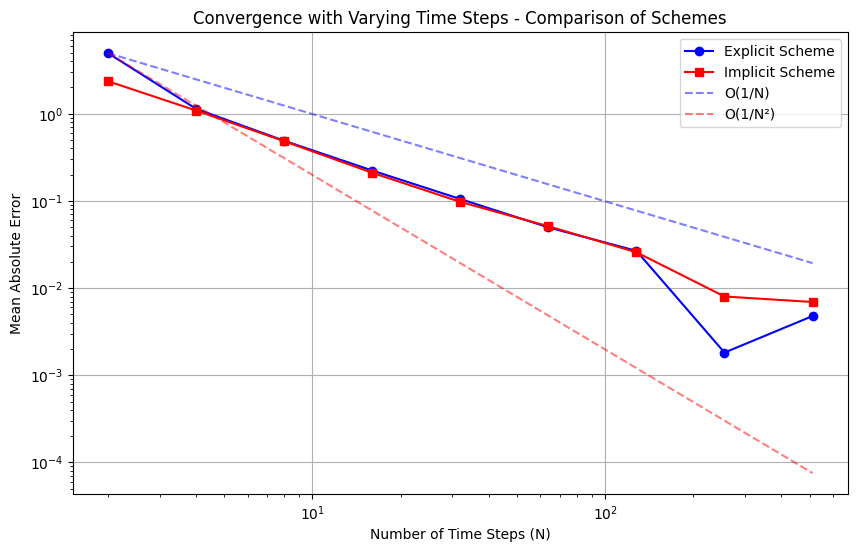


--- Testing convergence for both schemes with varying sample counts ---
Running with 2 samples...
  Explicit scheme error: 0.462984
  Implicit scheme error: 0.226043
Running with 8 samples...
  Explicit scheme error: 0.095107
  Implicit scheme error: 0.097713
Running with 32 samples...
  Explicit scheme error: 0.035934
  Implicit scheme error: 0.006308
Running with 128 samples...
  Explicit scheme error: 0.023574
  Implicit scheme error: 0.015609
Running with 512 samples...
  Explicit scheme error: 0.016939
  Implicit scheme error: 0.009918


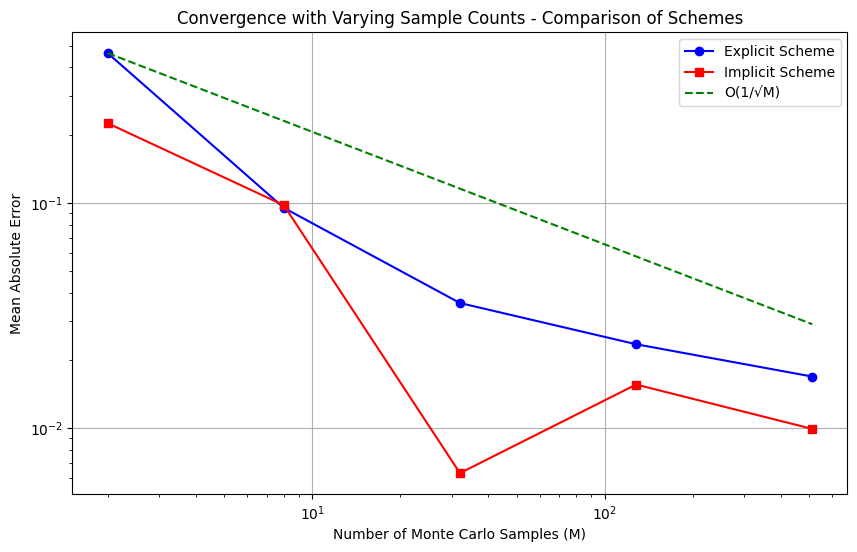

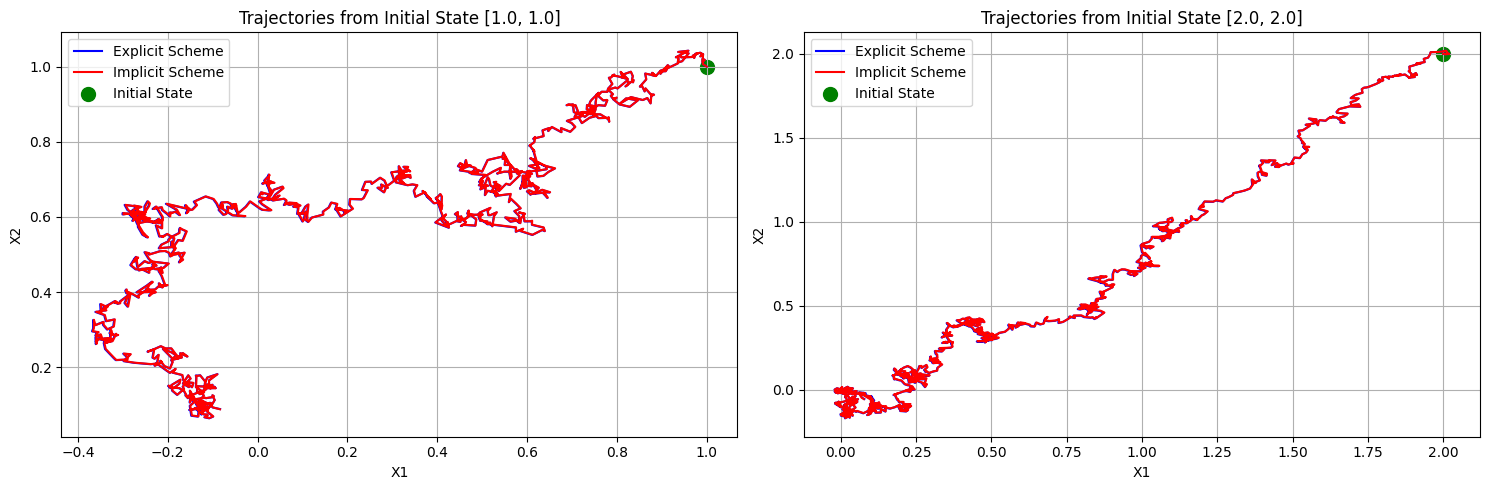

In [ ]:

main()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from typing import Tuple, Optional
import math

class SoftLQR(LQR):
    def __init__(self, H: torch.Tensor, M: torch.Tensor, sigma: torch.Tensor, 
                 C: torch.Tensor, D: torch.Tensor, R: torch.Tensor, 
                 T: float, time_grid: torch.Tensor,
                 tau: float, gamma: float):
        """
        Initialize the soft LQR problem with entropy regularization.
        
        Args:
            H: System dynamics matrix (d x d)
            M: Control input matrix (d x m)
            sigma: Noise matrix (d x d')
            C: State cost matrix (d x d)
            D: Control cost matrix (m x m)
            R: Terminal state cost matrix (d x d)
            T: Terminal time
            time_grid: Grid of time points
            tau: Entropy regularization strength
            gamma: Variance of prior normal density
        """
        super().__init__(H, M, sigma, C, D, R, T, time_grid)
        
        # Store additional parameters
        self.tau = tau
        self.gamma = gamma
        
        # Compute modified inverse term for the soft LQR
        # Σ⁻¹ = D + τ/(2γ²)I
        self.sigma_inv = self.D + (tau / (2 * gamma**2)) * torch.eye(self.m, dtype=self.D.dtype, device=self.D.device)
        self.sigma_term = torch.inverse(self.sigma_inv)
        
        # Compute determinant term for value function
        # C_D,τ,γ = -τ ln(τ^(m/2)/(γ^m * det(Σ)^(1/2)))
        self.CD_tau_gamma = -tau * math.log((tau**(self.m/2)) / (gamma**self.m * torch.sqrt(torch.det(self.sigma_term)).item()))

    def ricatti_rhs(self, t: float, S_flat: np.ndarray) -> np.ndarray:
        """
        Right-hand side of the modified Ricatti ODE for soft LQR:
        S'(t) = S(t)M(D + τ/(2γ²)I)^(-1)M^TS(t) - H^TS(t) - S(t)H - C
        
        Args:
            t: Time
            S_flat: Flattened S matrix
            
        Returns:
            Flattened derivative of S
        """
        # Reshape S from flattened form
        S = torch.tensor(S_flat.reshape(self.d, self.d), dtype=torch.float64)
        
        # Compute right-hand side with modified term
        term1 = S @ self.M @ self.sigma_term @ self.M.T @ S
        term2 = self.H.T @ S
        term3 = S @ self.H
        term4 = self.C
        
        # Compute derivative
        dS = term1 - term2 - term3 - term4
        
        # Return flattened result
        return dS.flatten().numpy()
    
    def compute_integral_term(self) -> None:
        """
        Compute the integral term for the value function: 
        int_t^T tr(sigma sigma^T S(r)) dr + (T-t) * C_D,τ,γ
        """
        if self.S_grid is None:
            self.solve_ricatti()
        
        # Compute trace term at each time point
        trace_terms = torch.zeros(len(self.time_grid))
        sigma_sigma_T = self.sigma @ self.sigma.T
        
        for i in range(len(self.time_grid)):
            trace_terms[i] = torch.trace(sigma_sigma_T @ self.S_grid[i])
        
        # Compute integral using trapezoidal rule (backward from T)
        integral_term = torch.zeros(len(self.time_grid))
        
        for i in range(len(self.time_grid) - 1, 0, -1):
            dt = self.time_grid[i] - self.time_grid[i-1]
            integral_term[i-1] = integral_term[i] + 0.5 * (trace_terms[i] + trace_terms[i-1]) * dt
        
        # Add the constant term proportional to (T-t)
        for i in range(len(self.time_grid)):
            integral_term[i] += (self.T - self.time_grid[i]) * self.CD_tau_gamma
        
        self.int_term_grid = integral_term
    
    def optimal_control_distribution(self, t: torch.Tensor, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute the parameters of the optimal control distribution:
        π*(·|t, x) = N(-(D + τ/(2γ²)I)^(-1)M^TS(t)x, τ(D + τ/(2γ²)I))
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Tuple of (mean, covariance) of optimal control distribution
        """
        # Get S matrices at the specified times
        S_matrices = self.get_S_at_time(t)
        
        # Compute mean for each (t, x) pair
        batch_size = x.shape[0]
        means = torch.zeros((batch_size, self.m), dtype=torch.float64, device=x.device)
        
        for i in range(batch_size):
            means[i] = -self.sigma_term @ self.M.T @ S_matrices[i] @ x[i]
        
        # The covariance is constant for all (t, x)
        covariance = self.tau * self.sigma_term
        
        return means, covariance
    
    def optimal_control(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Sample from the optimal control distribution.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Sampled control actions (batch x m)
        """
        means, covariance = self.optimal_control_distribution(t, x)
        
        # Create multivariate normal distribution
        batch_size = means.shape[0]
        samples = torch.zeros_like(means)
        
        # Sample from the distribution
        L = torch.linalg.cholesky(covariance)  # Lower triangular Cholesky factor
        
        for i in range(batch_size):
            # Generate standard normal samples
            z = torch.randn(self.m, dtype=torch.float64, device=means.device)
            # Transform to multivariate normal with the required covariance
            samples[i] = means[i] + L @ z
        
        return samples
    
def simulate_comparison(lqr: LQR, soft_lqr: SoftLQR, x0_list: list, num_steps: int, scheme: str = 'explicit') -> None:
    """
    Simulate and compare the standard LQR and soft LQR trajectories.
    
    Args:
        lqr: Standard LQR instance
        soft_lqr: Soft LQR instance
        x0_list: List of initial states to test
        num_steps: Number of time steps
        scheme: 'explicit' or 'implicit'
    """
    dt = lqr.T / num_steps
    t_grid = torch.linspace(0, lqr.T, num_steps + 1, dtype=torch.float64)
    
    # Ensure all matrices are double precision
    H = lqr.H.to(torch.float64)
    M = lqr.M.to(torch.float64)
    sigma = lqr.sigma.to(torch.float64)
    C = lqr.C.to(torch.float64)
    D = lqr.D.to(torch.float64)
    R = lqr.R.to(torch.float64)
    
    # Initialize plot
    fig, axes = plt.subplots(len(x0_list), 2, figsize=(16, 4*len(x0_list)))
    
    for i, x0 in enumerate(x0_list):
        # Convert initial state to tensor with explicit dtype
        x0_tensor = torch.tensor([x0], dtype=torch.float64)
        
        # Initialize trajectories and costs
        X_lqr = torch.zeros((num_steps + 1, 2), dtype=torch.float64)
        X_soft = torch.zeros((num_steps + 1, 2), dtype=torch.float64)
        X_lqr[0] = x0_tensor[0]
        X_soft[0] = x0_tensor[0]
        
        costs_lqr = torch.zeros(1, dtype=torch.float64)
        costs_soft = torch.zeros(1, dtype=torch.float64)
        
        # Generate same Brownian increments for both simulations
        dW = torch.randn((num_steps, sigma.shape[1]), dtype=torch.float64) * np.sqrt(dt)
        
        # For cost tracking
        running_costs_lqr = torch.zeros(num_steps + 1, dtype=torch.float64)
        running_costs_soft = torch.zeros(num_steps + 1, dtype=torch.float64)
        
        # Simulate trajectories
        if scheme == 'explicit':
            # Explicit scheme
            for n in range(num_steps):
                t_n = t_grid[n]
                t_tensor = torch.tensor([t_n], dtype=torch.float64)
                
                # Standard LQR step
                control_lqr = lqr.optimal_control(t_tensor, X_lqr[n:n+1])
                control_lqr = control_lqr.to(torch.float64)  # Ensure double precision
                drift_lqr = H @ X_lqr[n].to(torch.float64) + M @ control_lqr[0]
                X_lqr[n+1] = X_lqr[n] + drift_lqr * dt + sigma @ dW[n]
                
                # Compute running cost for LQR - using scalar operations to avoid dtype issues
                X_lqr_n_flat = X_lqr[n].to(torch.float64)
                C_float64 = C.to(torch.float64)
                D_float64 = D.to(torch.float64)
                
                state_cost_lqr = torch.matmul(torch.matmul(X_lqr_n_flat, C_float64), X_lqr_n_flat).item()
                control_cost_lqr = torch.matmul(torch.matmul(control_lqr[0], D_float64), control_lqr[0]).item()
                
                running_costs_lqr[n+1] = running_costs_lqr[n] + (state_cost_lqr + control_cost_lqr) * dt
                
                # Soft LQR step
                control_soft = soft_lqr.optimal_control(t_tensor, X_soft[n:n+1])
                control_soft = control_soft.to(torch.float64)  # Ensure double precision
                drift_soft = H @ X_soft[n].to(torch.float64) + M @ control_soft[0]
                X_soft[n+1] = X_soft[n] + drift_soft * dt + sigma @ dW[n]
                
                # Compute running cost for soft LQR (includes entropy term)
                X_soft_n_flat = X_soft[n].to(torch.float64)
                
                state_cost_soft = torch.matmul(torch.matmul(X_soft_n_flat, C_float64), X_soft_n_flat).item()
                control_cost_soft = torch.matmul(torch.matmul(control_soft[0], D_float64), control_soft[0]).item()
                
                # Add entropy regularization term
                means, covariance = soft_lqr.optimal_control_distribution(t_tensor, X_soft[n:n+1])
                means = means.to(torch.float64)
                covariance = covariance.to(torch.float64)
                entropy_term = soft_lqr.tau * torch.log(torch.det(2 * math.pi * math.e * covariance)).item() / 2
                
                running_costs_soft[n+1] = running_costs_soft[n] + (state_cost_soft + control_cost_soft + entropy_term) * dt
        else:
            # Implicit scheme
            # Identity matrix for linear system
            I = torch.eye(2, dtype=torch.float64)
            
            for n in range(num_steps):
                t_n = t_grid[n]
                t_np1 = t_grid[n+1]
                t_tensor = torch.tensor([t_n], dtype=torch.float64)
                t_np1_tensor = torch.tensor([t_np1], dtype=torch.float64)
                
                # Standard LQR
                control_lqr = lqr.optimal_control(t_tensor, X_lqr[n:n+1])
                control_lqr = control_lqr.to(torch.float64)  # Ensure double precision
                S_np1_lqr = lqr.get_S_at_time(t_np1_tensor)[0].to(torch.float64)
                D_inv_float64 = lqr.D_inv.to(torch.float64)
                A_lqr = I - dt * H + dt * M @ D_inv_float64 @ M.T @ S_np1_lqr
                b_lqr = X_lqr[n] + sigma @ dW[n]
                X_lqr[n+1] = torch.linalg.solve(A_lqr, b_lqr)
                
                # Compute running cost for LQR
                X_lqr_n_flat = X_lqr[n].to(torch.float64)
                C_float64 = C.to(torch.float64)
                D_float64 = D.to(torch.float64)
                
                state_cost_lqr = torch.matmul(torch.matmul(X_lqr_n_flat, C_float64), X_lqr_n_flat).item()
                control_cost_lqr = torch.matmul(torch.matmul(control_lqr[0], D_float64), control_lqr[0]).item()
                
                running_costs_lqr[n+1] = running_costs_lqr[n] + (state_cost_lqr + control_cost_lqr) * dt
                
                # Soft LQR
                control_soft = soft_lqr.optimal_control(t_tensor, X_soft[n:n+1])
                control_soft = control_soft.to(torch.float64)  # Ensure double precision
                S_np1_soft = soft_lqr.get_S_at_time(t_np1_tensor)[0].to(torch.float64)
                sigma_term_float64 = soft_lqr.sigma_term.to(torch.float64)
                A_soft = I - dt * H + dt * M @ sigma_term_float64 @ M.T @ S_np1_soft
                b_soft = X_soft[n] + sigma @ dW[n]
                X_soft[n+1] = torch.linalg.solve(A_soft, b_soft)
                
                # Compute running cost for soft LQR (includes entropy term)
                X_soft_n_flat = X_soft[n].to(torch.float64)
                
                state_cost_soft = torch.matmul(torch.matmul(X_soft_n_flat, C_float64), X_soft_n_flat).item()
                control_cost_soft = torch.matmul(torch.matmul(control_soft[0], D_float64), control_soft[0]).item()
                
                # Add entropy regularization term
                means, covariance = soft_lqr.optimal_control_distribution(t_tensor, X_soft[n:n+1])
                means = means.to(torch.float64)
                covariance = covariance.to(torch.float64)
                entropy_term = soft_lqr.tau * torch.log(torch.det(2 * math.pi * math.e * covariance)).item() / 2
                
                running_costs_soft[n+1] = running_costs_soft[n] + (state_cost_soft + control_cost_soft + entropy_term) * dt
        
        # Add terminal costs
        X_lqr_T = X_lqr[-1].to(torch.float64)
        X_soft_T = X_soft[-1].to(torch.float64)
        R_float64 = R.to(torch.float64)
        
        terminal_cost_lqr = torch.matmul(torch.matmul(X_lqr_T, R_float64), X_lqr_T).item()
        terminal_cost_soft = torch.matmul(torch.matmul(X_soft_T, R_float64), X_soft_T).item()
        
        running_costs_lqr[-1] += terminal_cost_lqr
        running_costs_soft[-1] += terminal_cost_soft
        
        # Total final costs
        costs_lqr = running_costs_lqr[-1]
        costs_soft = running_costs_soft[-1]
        
        # Plot trajectories
        ax1 = axes[i, 0] if len(x0_list) > 1 else axes[0]
        ax1.plot(X_lqr[:, 0].numpy(), X_lqr[:, 1].numpy(), 'b-', label='Standard LQR')
        ax1.plot(X_soft[:, 0].numpy(), X_soft[:, 1].numpy(), 'r-', label='Soft LQR')
        ax1.scatter([x0[0]], [x0[1]], color='g', s=100, marker='o', label='Initial State')
        ax1.set_title(f'Trajectories from Initial State {x0}')
        ax1.set_xlabel('X1')
        ax1.set_ylabel('X2')
        ax1.grid(True)
        ax1.legend()
        
        # Plot costs over time
        ax2 = axes[i, 1] if len(x0_list) > 1 else axes[1]
        ax2.plot(t_grid.numpy(), running_costs_lqr.numpy(), 'b-', label='Standard LQR Cost')
        ax2.plot(t_grid.numpy(), running_costs_soft.numpy(), 'r-', label='Soft LQR Cost')
        ax2.set_title(f'Cost Over Time from Initial State {x0}')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Cost')
        ax2.grid(True)
        ax2.legend()
        
        print(f"Initial state {x0}:")
        print(f"  Standard LQR final cost: {float(costs_lqr):.2f}")
        print(f"  Soft LQR final cost: {float(costs_soft):.2f}")
    
    plt.tight_layout()
    plt.show()

def main_soft_lqr():
    # Set the problem matrices as specified in Figure 1
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 0.1
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set the terminal time and time grid
    T = 0.5
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Set entropy regularization parameters
    tau = 0.1
    gamma = 10.0
    
    # Create standard LQR instance
    lqr = LQR(H, M, sigma, C, D, R, T, time_grid)
    
    # Create soft LQR instance
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    
    # Solve Ricatti ODEs
    lqr.solve_ricatti()
    soft_lqr.solve_ricatti()
    
    # Print S matrices at key time points
    print("Standard LQR S(0):\n", lqr.S_grid[0])
    print("Soft LQR S(0):\n", soft_lqr.S_grid[0])
    
    # Test points for trajectory comparison
    initial_states = [
        [2.0, 2.0],
        [2.0, -2.0],
        [-2.0, -2.0],
        [-2.0, 2.0]
    ]
    
    # Compare trajectories
    simulate_comparison(lqr, soft_lqr, initial_states, num_steps=200, scheme='explicit')

    

In [ ]:
# This would require installing torchdiffeq: pip install torchdiffeq
class GPUSoftLQR(SoftLQR):
    def solve_ricatti(self) -> None:
        """
        Solve the Ricatti ODE using torchdiffeq for GPU acceleration.
        """
        from torchdiffeq import odeint

        # Convert matrices to double precision and move to the proper device
        self.H = self.H.to(torch.float64, device=self.device)
        self.M = self.M.to(torch.float64, device=self.device)
        self.sigma = self.sigma.to(torch.float64, device=self.device)
        self.C = self.C.to(torch.float64, device=self.device)
        self.D = self.D.to(torch.float64, device=self.device)
        self.R = self.R.to(torch.float64, device=self.device)
        self.D_inv = self.D_inv.to(torch.float64, device=self.device)
        self.sigma_inv = self.sigma_inv.to(torch.float64, device=self.device)
        self.sigma_term = self.sigma_term.to(torch.float64, device=self.device)
        
        # Define RiccatiODE as a torch.nn.Module for torchdiffeq
        class RiccatiODE(torch.nn.Module):

            def __init__(self, H, M, sigma_term, C, d):
                super().__init__()
                self.H = H
                self.M = M
                self.sigma_term = sigma_term
                self.C = C
                self.d = d
            
            def forward(self, t, S_flat):
                # Reshape S from flattened form
                S = S_flat.reshape(self.d, self.d)
                
                # Compute right-hand side
                term1 = S @ self.M @ self.sigma_term @ self.M.T @ S
                term2 = self.H.T @ S
                term3 = S @ self.H
                term4 = self.C
                
                # Compute derivative
                dS = term1 - term2 - term3 - term4
                
                # Return flattened result
                return dS.flatten()
        
        # Create the ODE module
        ode_fn = RiccatiODE(
            self.H, self.M, self.sigma_term, self.C, self.d
        )
        
        # Terminal condition: S(T) = R
        S_T_flat = self.R.flatten()
        
        # Time points for ODE solver (reversed for backward integration)
        t_points = self.time_grid
        t_reversed = self.T - t_points.flip(0)
        
        # Solve the ODE backward in time (from T to 0) using torchdiffeq
        with torch.no_grad():
            S_solution = odeint(
                ode_fn, 
                S_T_flat, 
                t_reversed, 
                method='dopri5',
                rtol=1e-10, 
                atol=1e-10
            )
        
        # Reshape solution and reverse back to forward time
        S_matrices = S_solution.reshape(-1, self.d, self.d).flip(0)
        
        self.S_grid = S_matrices
        
        # Compute integral term for value function
        self.compute_integral_term()

Standard LQR S(0):
 tensor([[ 0.3698, -0.1901],
        [-0.1901,  0.5432]], dtype=torch.float64)
Soft LQR S(0):
 tensor([[ 0.3711, -0.1911],
        [-0.1911,  0.5454]], dtype=torch.float64)
Initial state [2.0, 2.0]:
  Standard LQR final cost: 2.21
  Soft LQR final cost: 2.46
Initial state [2.0, -2.0]:
  Standard LQR final cost: 4.35
  Soft LQR final cost: 4.60
Initial state [-2.0, -2.0]:
  Standard LQR final cost: 2.63
  Soft LQR final cost: 2.88
Initial state [-2.0, 2.0]:
  Standard LQR final cost: 4.08
  Soft LQR final cost: 4.34


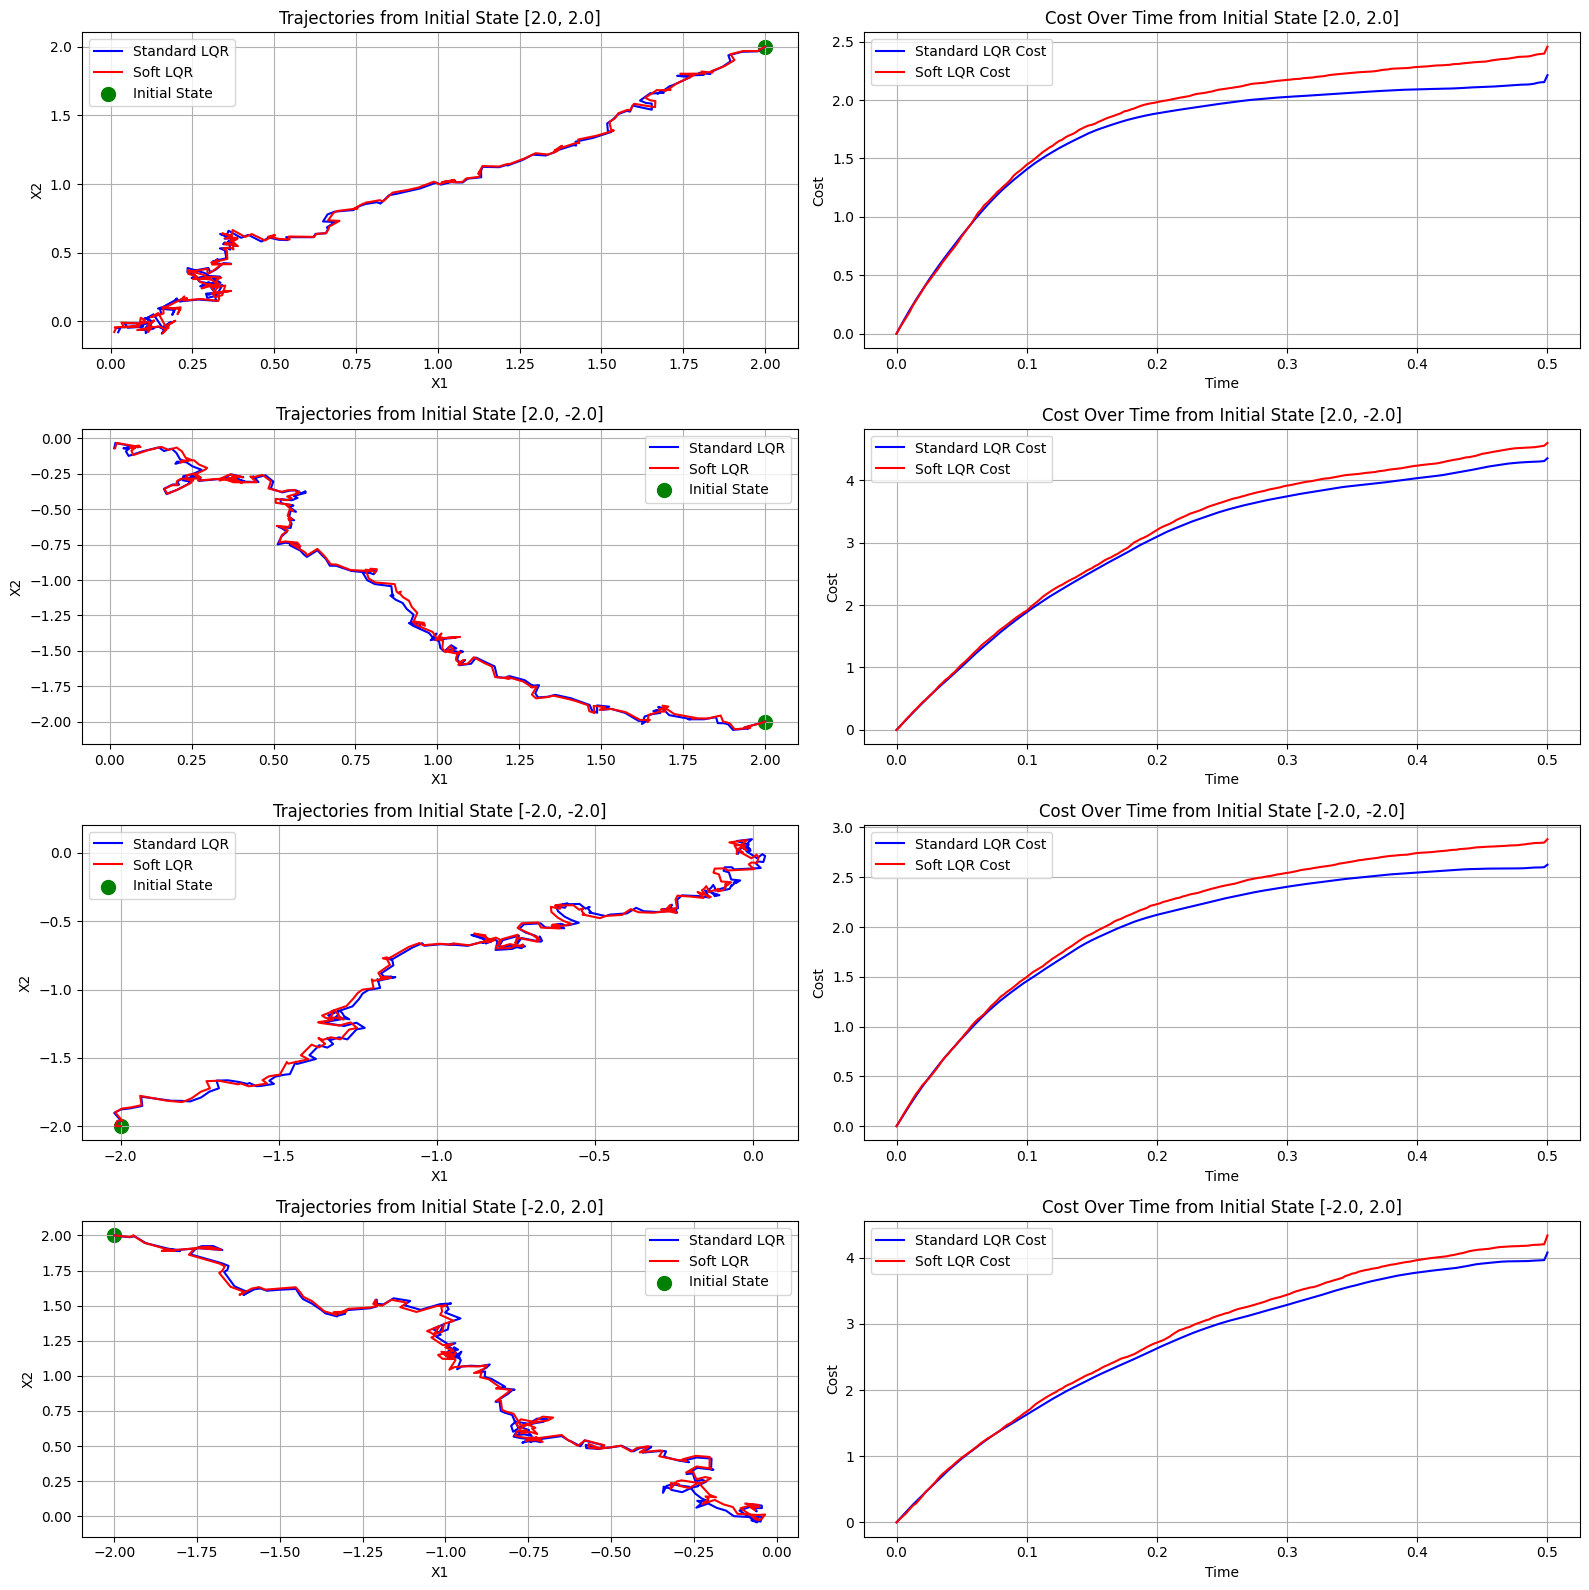

In [25]:
main_soft_lqr()

## Question 3

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import time

class ValueNN(nn.Module):
    """Neural network to approximate the value function for soft LQR.
    The value function is parameterized as v(t,x) = x^T K(t)x + R(t)."""
    
    def __init__(self, hidden_size=512, device=torch.device("cpu")):
        super(ValueNN, self).__init__()
        self.device = device
        
        # Explicitly set dtype for all layers
        dtype = torch.float64
        
        self.time_embedding = nn.Linear(1, hidden_size, device=device, dtype=dtype)
        self.hidden_layer1 = nn.Linear(hidden_size, hidden_size, device=device, dtype=dtype)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size, device=device, dtype=dtype)
        self.matrix_output = nn.Linear(hidden_size, 2*2, device=device, dtype=dtype)
        self.offset_output = nn.Linear(hidden_size, 1, device=device, dtype=dtype)
    
    def forward(self, t):
        """
        Forward pass through the network.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            Tuple of (matrix, offset) for value function approximation
        """
        # Ensure t is properly shaped
        t = t.view(-1, 1)
        
        # Forward pass through time embedding and hidden layers
        x = torch.relu(self.time_embedding(t))
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        
        # Get matrix elements and reshape to batch of 2x2 matrices
        matrix_elements = self.matrix_output(x)
        batch_matrices = matrix_elements.view(-1, 2, 2)
        
        # Make the matrices positive semi-definite (symmetric and positive)
        matrices = torch.matmul(batch_matrices, batch_matrices.transpose(1, 2))
        matrices = matrices + 1e-3 * torch.eye(2, device=self.device).unsqueeze(0)
        
        # Get offset term
        offset = self.offset_output(x)
        
        return matrices, offset
    
    def value_function(self, t, x):
        """
        Compute the value function v(t,x) = x^T K(t)x + R(t).
        
        Args:
            t: Time tensor (batch) 
            x: State tensor (batch x 2)
            
        Returns:
            Value function at (t, x) (batch)
        """
        # Ensure consistent dtypes
        t = t.to(torch.float64)
        x = x.to(torch.float64)
        
        matrices, offsets = self.forward(t)
        
        # Ensure matrices and offsets are float64
        matrices = matrices.to(torch.float64)
        offsets = offsets.to(torch.float64)
        
        # Compute quadratic term x^T K(t)x
        batch_size = x.shape[0]
        values = torch.zeros(batch_size, device=x.device, dtype=torch.float64)
        
        for i in range(batch_size):
            values[i] = x[i] @ matrices[i] @ x[i]
        
        # Add offset term
        values = values + offsets.squeeze()
        
        return values


class CriticAlgorithm:
    """Implementation of the critic algorithm for soft LQR."""
    
    def __init__(self, 
                 soft_lqr: SoftLQR, 
                 hidden_size: int = 512, 
                 learning_rate: float = 1e-3,
                 device: torch.device = torch.device("cpu")):
        """
        Initialize the critic algorithm.
        """
        self.soft_lqr = soft_lqr
        self.device = device
        
        # Create value network - explicitly set dtype to float64
        self.value_network = ValueNN(hidden_size=hidden_size, device=device).to(device)
        
        # Convert network parameters to double precision
        for param in self.value_network.parameters():
            param.data = param.data.to(torch.float64)
        
        # Create optimizer
        self.optimizer = optim.Adam(self.value_network.parameters(), lr=learning_rate)
        
        # MSE loss function
        self.criterion = nn.MSELoss()
        
        # For tracking progress
        self.loss_history = []
    
    def _generate_batch(self, batch_size: int, state_range: float = 3.0) -> Tuple[torch.Tensor, torch.Tensor]:
        """Generate a batch of random states and times for training."""
        # Sample times uniformly from [0, T] - explicitly specify dtype
        times = torch.rand(batch_size, device=self.device, dtype=torch.float64) * self.soft_lqr.T
        
        # Sample states uniformly from [-state_range, state_range]^2
        states = (torch.rand(batch_size, 2, device=self.device, dtype=torch.float64) * 2 - 1) * state_range
        
        return times, states
    
    def _compute_target_values(self, t: torch.Tensor, x: torch.Tensor, num_steps: int = 100) -> torch.Tensor:
        """Compute target values by simulating trajectories and computing costs."""
        batch_size = t.shape[0]
        target_values = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        
        for i in range(batch_size):
            # Current time and state
            t_i = t[i].item()
            x_i = x[i:i+1]  # Keep batch dimension
            
            # If we're already at terminal time, return terminal cost
            if t_i >= self.soft_lqr.T - 1e-6:
                target_values[i] = torch.matmul(torch.matmul(x_i.squeeze(), self.soft_lqr.R), x_i.squeeze())
                continue
            
            # Determine remaining time and step size
            remaining_time = self.soft_lqr.T - t_i
            dt = remaining_time / num_steps
            
            # Initialize state and cost
            current_state = x_i.clone()
            cost = 0.0
            
            # Simulate trajectory
            for step in range(num_steps):
                # Current time - explicitly set dtype to float64
                current_time = t_i + step * dt
                current_time_tensor = torch.tensor([current_time], device=self.device, dtype=torch.float64)
                
                # Get control distribution and sample
                means, covariance = self.soft_lqr.optimal_control_distribution(current_time_tensor, current_state)
                
                # Explicit conversion to float64 to ensure consistency
                means = means.to(torch.float64)
                covariance = covariance.to(torch.float64)
                
                # Sample from the distribution - critical fix here
                L = torch.linalg.cholesky(covariance)
                z = torch.randn(self.soft_lqr.m, device=self.device, dtype=torch.float64)
                control = means.squeeze() + L @ z
                control = control.unsqueeze(0)  # Add batch dimension back
                
                # Compute running cost
                state_cost = torch.matmul(torch.matmul(current_state.squeeze(), self.soft_lqr.C), current_state.squeeze())
                control_cost = torch.matmul(torch.matmul(control.squeeze(), self.soft_lqr.D), control.squeeze())
                
                # Add entropy regularization term - ensure consistent dtype
                entropy_term = self.soft_lqr.tau * torch.log(torch.det(2 * np.pi * np.e * covariance)) / 2
                
                # Accumulate cost
                cost += (state_cost + control_cost + entropy_term) * dt
                
                # Update state with Euler step
                drift = self.soft_lqr.H @ current_state.squeeze() + self.soft_lqr.M @ control.squeeze()
                noise = self.soft_lqr.sigma @ torch.randn(self.soft_lqr.sigma.shape[1], 
                                                         device=self.device, 
                                                         dtype=torch.float64) * np.sqrt(dt)
                current_state = current_state + (drift * dt + noise).unsqueeze(0)
            
            # Add terminal cost
            terminal_cost = torch.matmul(torch.matmul(current_state.squeeze(), self.soft_lqr.R), current_state.squeeze())
            cost += terminal_cost
            
            target_values[i] = cost
        
        return target_values

    def train_step(self, batch_size: int) -> float:
        """Perform one training step of the critic algorithm."""
        # Generate batch
        times, states = self._generate_batch(batch_size)
        
        # Compute target values
        with torch.no_grad():
            target_values = self._compute_target_values(times, states)
        
        # Compute predicted values
        predicted_values = self.value_network.value_function(times, states)
        
        # Ensure consistent dtype before computing loss
        predicted_values = predicted_values.to(torch.float64)
        target_values = target_values.to(torch.float64)
        
        # Compute loss
        loss = self.criterion(predicted_values, target_values)
        
        # Perform optimization step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self, num_epochs: int, batch_size: int, 
              eval_interval: int = 10, eval_grid_size: int = 5) -> None:
        """
        Train the critic network.
        
        Args:
            num_epochs: Number of training epochs
            batch_size: Batch size for training
            eval_interval: Interval for evaluation
            eval_grid_size: Grid size for evaluation
        """
        print("Starting critic training...")
        start_time = time.time()
        
        for epoch in range(num_epochs):
            loss = self.train_step(batch_size)
            self.loss_history.append(loss)
            
            if (epoch + 1) % eval_interval == 0 or epoch == 0:
                # Evaluate current performance
                max_error = self.evaluate(eval_grid_size)
                elapsed = time.time() - start_time
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.6e}, Max Error: {max_error:.6e}, Time: {elapsed:.2f}s")
        
        print(f"Training completed in {time.time() - start_time:.2f} seconds.")
    
    def evaluate(self, grid_size: int = 5, state_range: float = 3.0, 
             time_points: Optional[List[float]] = None) -> float:
        """
        Evaluate the critic network against the exact value function.
        
        Args:
            grid_size: Number of points in each dimension for evaluation
            state_range: Range for evaluation grid
            time_points: Specific time points for evaluation, defaults to [0, T/3, 2T/3, T]
            
        Returns:
            Maximum absolute error
        """
        # Set default time points if not provided
        if time_points is None:
            time_points = [0, self.soft_lqr.T/3, 2*self.soft_lqr.T/3, self.soft_lqr.T]
        
        # Create evaluation grid - explicitly specify dtype as float64
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Convert time points to tensor with explicit dtype
        time_tensor = torch.tensor(time_points, device=self.device, dtype=torch.float64)
        
        # Store maximum error
        max_error = 0.0
        
        # Evaluate on grid
        with torch.no_grad():
            for t_idx, t in enumerate(time_tensor):
                t_batch = t.unsqueeze(0)
                for i in range(grid_size):
                    for j in range(grid_size):
                        # Current state with explicit dtype
                        x = torch.tensor([[x_grid[i], y_grid[j]]], device=self.device, dtype=torch.float64)
                        
                        # Compute exact value function
                        exact_value = self.soft_lqr.value_function(t_batch, x)
                        
                        # Compute approximate value function
                        approx_value = self.value_network.value_function(t_batch, x)
                        
                        # Ensure both values have the same dtype before comparison
                        exact_value = exact_value.to(torch.float64)
                        approx_value = approx_value.to(torch.float64)
                        
                        # Update maximum error
                        error = torch.abs(exact_value - approx_value).item()
                        max_error = max(max_error, error)
        
        return max_error
    
    def plot_loss_history(self) -> None:
        """Plot the loss history during training."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Critic Loss History')
        plt.grid(True)
        plt.show()
    
    def plot_value_function_comparison(self, grid_size: int = 20, state_range: float = 3.0):
        """
        Plot comparison between exact and learned value function.
        
        Args:
            grid_size: Number of points in each dimension for plotting
            state_range: Range for plotting grid
        """
        # Create evaluation grid with explicit float64 dtype
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Evaluation time (t=0)
        t = torch.tensor([0.0], device=self.device, dtype=torch.float64)
        
        # Initialize arrays for values
        X, Y = np.meshgrid(x_grid.cpu().numpy(), y_grid.cpu().numpy())
        exact_values = np.zeros((grid_size, grid_size))
        approx_values = np.zeros((grid_size, grid_size))
        errors = np.zeros((grid_size, grid_size))
        
        # Compute values on grid
        with torch.no_grad():
            for i in range(grid_size):
                for j in range(grid_size):
                    # Current state with explicit float64 dtype
                    x = torch.tensor([[x_grid[i].item(), y_grid[j].item()]], 
                                    device=self.device, dtype=torch.float64)
                    
                    # Compute exact value function - must convert to float64 first
                    exact_value = self.soft_lqr.value_function(t, x).item()
                    
                    # Compute approximate value function
                    # Make sure network inputs are float64
                    approx_value = self.value_network.value_function(
                        self._ensure_float64(t), 
                        self._ensure_float64(x)
                    ).item()
                    
                    # Store values
                    exact_values[j, i] = exact_value
                    approx_values[j, i] = approx_value
                    errors[j, i] = np.abs(exact_value - approx_value)
        
        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot exact value function
        im1 = axes[0].contourf(X, Y, exact_values, 50, cmap='viridis')
        axes[0].set_title('Exact Value Function at t=0')
        axes[0].set_xlabel('x1')
        axes[0].set_ylabel('x2')
        plt.colorbar(im1, ax=axes[0])
        
        # Plot approximate value function
        im2 = axes[1].contourf(X, Y, approx_values, 50, cmap='viridis')
        axes[1].set_title('Learned Value Function at t=0')
        axes[1].set_xlabel('x1')
        axes[1].set_ylabel('x2')
        plt.colorbar(im2, ax=axes[1])
        
        # Plot error
        im3 = axes[2].contourf(X, Y, errors, 50, cmap='hot')
        axes[2].set_title('Absolute Error')
        axes[2].set_xlabel('x1')
        axes[2].set_ylabel('x2')
        plt.colorbar(im3, ax=axes[2])
        
        plt.tight_layout()
        plt.show()

    def _ensure_float64(self, tensor):
        """Helper method to ensure tensors are consistently float64."""
        if tensor.dtype != torch.float64:
            return tensor.to(torch.float64)
        return tensor


def run_critic_algorithm():
    """Run the critic algorithm for soft LQR."""
    # Set the problem matrices as specified in assignment
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    
    # Use identity matrix for D as specified in the hints
    D = torch.eye(2, dtype=torch.float64) 
    
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set parameters as specified in the hints
    T = 0.5
    tau = 0.5
    gamma = 1.0
    
    # Create time grid with N=100 as specified
    N = 100
    time_grid = torch.linspace(0, T, N+1, dtype=torch.float64)
    
    # Create soft LQR instance and solve Ricatti ODE
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    soft_lqr.solve_ricatti()
    
    # Create critic algorithm
    critic = CriticAlgorithm(soft_lqr, hidden_size=512, learning_rate=1e-3)
    
    # Train critic
    critic.train(num_epochs=500, batch_size=64, eval_interval=20)
    
    # Plot results
    critic.plot_loss_history()
    critic.plot_value_function_comparison()
    
    # Evaluate final performance
    max_error = critic.evaluate(grid_size=10)
    print(f"Final maximum error: {max_error:.6e}")
    
    return critic



Starting critic training...
Epoch 1/500, Loss: 1.628275e+03, Max Error: 2.318700e+02, Time: 7.35s
Epoch 20/500, Loss: 1.036656e+02, Max Error: 1.661571e+02, Time: 74.56s
Epoch 40/500, Loss: 2.386576e+02, Max Error: 1.584234e+02, Time: 121.11s
Epoch 60/500, Loss: 6.656581e+01, Max Error: 1.366515e+02, Time: 167.20s
Epoch 80/500, Loss: 4.023906e+01, Max Error: 1.345265e+02, Time: 213.23s
Epoch 100/500, Loss: 8.747229e+01, Max Error: 8.574983e+01, Time: 258.90s
Epoch 120/500, Loss: 4.519607e+01, Max Error: 9.229944e+01, Time: 304.44s
Epoch 140/500, Loss: 4.144290e+01, Max Error: 7.005013e+01, Time: 350.22s
Epoch 160/500, Loss: 2.311024e+01, Max Error: 8.593292e+01, Time: 396.05s
Epoch 180/500, Loss: 2.819381e+01, Max Error: 8.825198e+01, Time: 441.69s
Epoch 200/500, Loss: 3.318915e+01, Max Error: 9.551817e+01, Time: 488.11s
Epoch 220/500, Loss: 3.322860e+01, Max Error: 4.404204e+01, Time: 533.79s
Epoch 240/500, Loss: 3.209537e+01, Max Error: 6.195509e+01, Time: 579.40s
Epoch 260/500, Loss

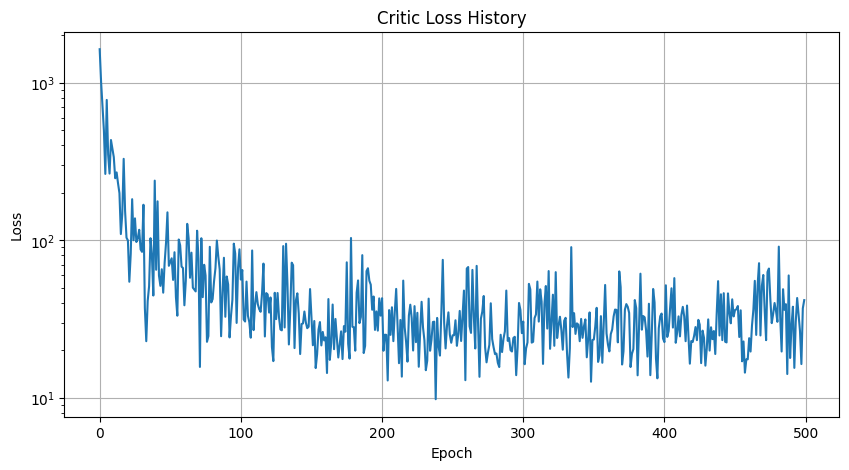

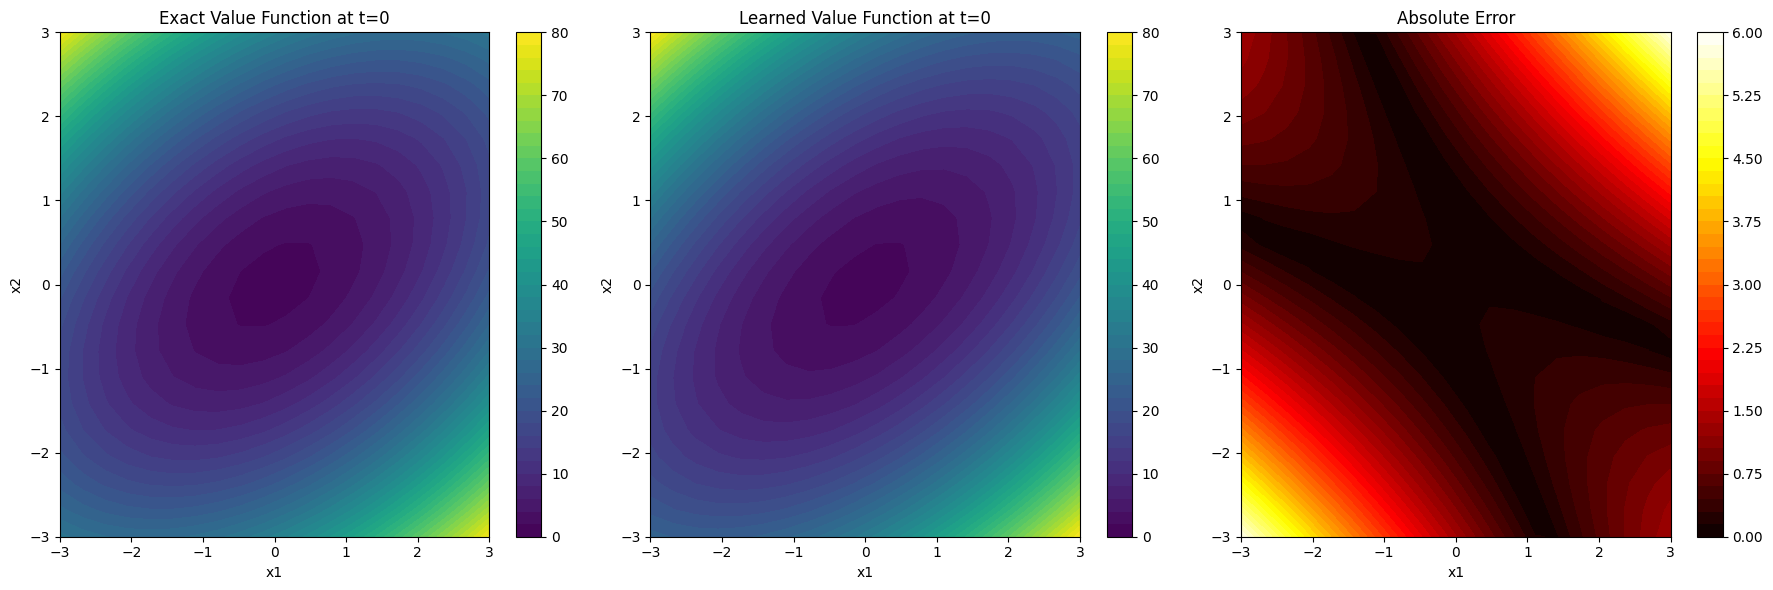

Final maximum error: 6.019483e+01


In [53]:
run_critic_algorithm()

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import time

class PolicyNN(nn.Module):
    """Neural network to approximate the optimal policy for soft LQR.
    Outputs the mean and covariance of the control distribution."""
    
    def __init__(self, d=2, hidden_size=256, device=torch.device("cpu")):
        super(PolicyNN, self).__init__()
        self.d = d  # State dimension
        self.device = device
        
        # Create neural network with 3 hidden layers, all explicitly using float64
        self.time_embedding = nn.Linear(1, hidden_size, device=device, dtype=torch.float64)
        self.hidden_layer1 = nn.Linear(hidden_size, hidden_size, device=device, dtype=torch.float64)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size, device=device, dtype=torch.float64)
        
        # Output layers for action distribution parameters
        # Output for phi(t) - mapping from state to control mean
        self.phi_output = nn.Linear(hidden_size, d * d, device=device, dtype=torch.float64)
        
        # Output for elements of the L matrix for Sigma(t) - covariance matrix
        # For d=2, we need 3 values (lower triangular elements)
        self.sigma_output_L = nn.Linear(hidden_size, d * (d + 1) // 2, device=device, dtype=torch.float64)
        
        # Precompute indices for building the lower triangular matrix
        self.tri_indices = torch.tril_indices(d, d).to(device)

    def _ensure_float64(self, tensor):
        """Helper method to ensure tensors are consistently float64."""
        if tensor.dtype != torch.float64:
            return tensor.to(torch.float64)
        return tensor
        
    def forward(self, t):
        """
        Forward pass to compute policy parameters.
        
        Args:
            t: Time tensor (batch)
            
        Returns:
            Tuple of (phi, Sigma) for policy approximation
        """
        # Ensure t is properly shaped and dtype
        t = self._ensure_float64(t.view(-1, 1))
        
        # Forward pass through the network
        x = torch.relu(self.time_embedding(t))
        x = torch.relu(self.hidden_layer1(x))
        x = torch.sigmoid(self.hidden_layer2(x))
        
        # Compute phi - matrix mapping state to mean of control distribution
        phi_flat = self.phi_output(x)
        phi = phi_flat.view(-1, self.d, self.d)
        
        # Compute L for covariance matrix Sigma = LL^T (ensures positive semi-definiteness)
        L_flat = self.sigma_output_L(x)
        
        # Create batched lower triangular matrices
        batch_size = t.shape[0]
        L = torch.zeros(batch_size, self.d, self.d, device=self.device, dtype=torch.float64)
        
        # Fill in the lower triangular elements
        for i in range(batch_size):
            L[i][self.tri_indices[0], self.tri_indices[1]] = L_flat[i]
        
        # Compute Sigma = LL^T
        Sigma = torch.bmm(L, L.transpose(1, 2))
        
        return phi, Sigma
    
    def action_distribution(self, t, x):
        """
        Compute the parameters of the control distribution.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Tuple of (means, covariance) for the control distribution
        """
        # Ensure inputs are float64
        t = self._ensure_float64(t)
        x = self._ensure_float64(x)
        
        # Get policy parameters
        phi, Sigma = self.forward(t)
        
        # Compute means for each (t, x) pair: mean = phi(t) @ x
        batch_size = x.shape[0]
        means = torch.bmm(phi, x.unsqueeze(2)).squeeze(2)
        
        # In this formulation, Sigma is the covariance matrix, which depends only on t
        return means, Sigma
    
    def sample_action(self, t, x):
        """
        Sample from the control distribution.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            
        Returns:
            Sampled control actions (batch x d)
        """
        means, covariances = self.action_distribution(t, x)
        
        # Sample from multivariate normal distributions
        batch_size = means.shape[0]
        actions = torch.zeros_like(means)
        
        for i in range(batch_size):
            # Compute Cholesky decomposition for sampling
            L = torch.linalg.cholesky(covariances[i])
            
            # Generate standard normal samples
            z = torch.randn(self.d, device=self.device, dtype=torch.float64)
            
            # Transform to multivariate normal: mean + L @ z
            actions[i] = means[i] + L @ z
        
        return actions


class ActorAlgorithm:
    """Implementation of the actor algorithm for soft LQR, which learns 
    the optimal policy using the exact value function."""
    
    def __init__(self, 
                 soft_lqr: SoftLQR, 
                 hidden_size: int = 256, 
                 learning_rate: float = 1e-4,
                 device: torch.device = torch.device("cpu")):
        """
        Initialize the actor algorithm.
        
        Args:
            soft_lqr: Instance of SoftLQR class with exact value function
            hidden_size: Size of hidden layers in the policy network
            learning_rate: Learning rate for optimization
            device: Device to use for computation
        """
        self.soft_lqr = soft_lqr
        self.device = device
        
        # Create policy network
        self.policy_network = PolicyNN(d=soft_lqr.d, hidden_size=hidden_size, device=device).to(device)
        
        # Create optimizer
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
        
        # For tracking progress
        self.loss_history = []
    
    def _ensure_float64(self, tensor):
        """Helper method to ensure tensors are consistently float64."""
        if tensor.dtype != torch.float64:
            return tensor.to(torch.float64)
        return tensor
    
    def _generate_batch(self, batch_size: int, state_range: float = 3.0) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate a batch of random states and times for training.
        
        Args:
            batch_size: Number of samples to generate
            state_range: Range for uniform sampling of states
            
        Returns:
            Tuple of (times, states) tensors
        """
        # Sample times uniformly from [0, T]
        times = torch.rand(batch_size, device=self.device, dtype=torch.float64) * self.soft_lqr.T
        
        # Sample states uniformly from [-state_range, state_range]^2
        states = (torch.rand(batch_size, self.soft_lqr.d, device=self.device, dtype=torch.float64) * 2 - 1) * state_range
        
        return times, states
    
    def compute_policy_gradient(self, t, x, num_steps=10) -> torch.Tensor:
        """
        Compute the policy gradient for updating the policy network.
        Uses the exact value function from soft_lqr.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            num_steps: Number of simulation steps per trajectory
            
        Returns:
            Policy gradient for each sample in the batch
        """
        batch_size = t.shape[0]
        
        # Initialize accumulated gradient
        total_grad = 0.0
        
        for i in range(batch_size):
            t_i = t[i].item()
            x_i = x[i:i+1]
            
            # If we're at terminal time, no need to compute gradient
            if t_i >= self.soft_lqr.T - 1e-6:
                continue
            
            # Get action distribution from the policy network
            t_tensor = t[i:i+1]
            means, covariances = self.policy_network.action_distribution(t_tensor, x_i)
            
            # Get optimal action distribution from the soft LQR solution
            optimal_means, optimal_covariance = self.soft_lqr.optimal_control_distribution(t_tensor, x_i)
            
            # Ensure tensors have the correct shape and dimensionality
            # The error occurs here - optimal_covariances might not be batched correctly
            
            # Make sure we have properly shaped 2D tensors for matrix operations
            mean = means[0] if means.dim() > 1 else means
            optimal_mean = optimal_means[0] if optimal_means.dim() > 1 else optimal_means
            
            # For covariances - ensure they're 2D matrices
            # The SoftLQR might return a non-batched covariance (single 2D matrix)
            covariance = covariances[0] if covariances.dim() > 2 else covariances
            
            # This is the line that's causing the problem - ensure optimal_covariance is a 2D matrix
            # It might be a scalar or 1D tensor currently
            if optimal_covariance.dim() < 2:
                # If it's somehow a scalar or 1D, reshape it appropriately
                optimal_covariance = optimal_covariance.reshape(self.soft_lqr.m, self.soft_lqr.m)
            elif optimal_covariance.dim() > 2:
                # If it's batched (3D), take the first element
                optimal_covariance = optimal_covariance[0]
                
            # Now compute precision matrix (should work with 2D matrix)
            optimal_precision = torch.inverse(optimal_covariance)
            
            # Compute mean difference - ensure these are 1D vectors
            mean_diff = optimal_mean - mean
            
            # Compute terms of KL divergence
            term1 = torch.trace(optimal_precision @ covariance)
            term2 = (mean_diff @ optimal_precision @ mean_diff)
            term3 = self.soft_lqr.d  # dimensionality
            term4 = torch.log(torch.det(optimal_covariance) / torch.det(covariance))
            
            # Compute KL divergence
            kl_div = 0.5 * (term1 + term2 - term3 + term4)
            
            # Accumulate gradient (we want to minimize KL divergence)
            total_grad += kl_div
        
        # Return average gradient
        return total_grad / batch_size
    
    def train_step(self, batch_size: int) -> float:
        """
        Perform one training step of the actor algorithm.
        
        Args:
            batch_size: Batch size for training
            
        Returns:
            Loss value from this step
        """
        # Generate batch
        times, states = self._generate_batch(batch_size)
        
        # Compute policy gradient
        loss = self.compute_policy_gradient(times, states)
        
        # Perform optimization step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def train(self, num_epochs: int, batch_size: int, eval_interval: int = 10) -> None:
        """
        Train the actor network.
        
        Args:
            num_epochs: Number of training epochs
            batch_size: Batch size for training
            eval_interval: Interval for evaluation and progress reporting
        """
        print("Starting actor training...")
        start_time = time.time()
        
        for epoch in range(num_epochs):
            loss = self.train_step(batch_size)
            self.loss_history.append(loss)
            
            if (epoch + 1) % eval_interval == 0 or epoch == 0:
                # Evaluate current performance
                mean_error, cov_error = self.evaluate()
                elapsed = time.time() - start_time
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.6e}, Mean Error: {mean_error:.6e}, Cov Error: {cov_error:.6e}, Time: {elapsed:.2f}s")
        
        print(f"Training completed in {time.time() - start_time:.2f} seconds.")
    
    def evaluate(self, grid_size: int = 5, state_range: float = 3.0, time_points: Optional[List[float]] = None) -> Tuple[float, float]:
        """
        Evaluate the actor network against the exact optimal policy.
        
        Args:
            grid_size: Number of points in each dimension for evaluation
            state_range: Range for evaluation grid
            time_points: Specific time points for evaluation, defaults to [0, T/3, 2T/3, T]
            
        Returns:
            Tuple of (mean_error, covariance_error)
        """
        # Set default time points if not provided
        if time_points is None:
            time_points = [0, self.soft_lqr.T/3, 2*self.soft_lqr.T/3, self.soft_lqr.T]
        
        # Create evaluation grid
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Convert time points to tensor
        time_tensor = torch.tensor(time_points, device=self.device, dtype=torch.float64)
        
        # Store maximum errors
        total_mean_error = 0.0
        total_cov_error = 0.0
        count = 0
        
        # Evaluate on grid
        with torch.no_grad():
            for t_idx, t in enumerate(time_tensor):
                t_batch = t.unsqueeze(0)
                for i in range(grid_size):
                    for j in range(grid_size):
                        # Current state
                        x = torch.tensor([[x_grid[i], y_grid[j]]], device=self.device, dtype=torch.float64)
                        
                        # Compute optimal policy parameters
                        optimal_means, optimal_cov = self.soft_lqr.optimal_control_distribution(t_batch, x)
                        
                        # Compute learned policy parameters
                        learned_means, learned_cov = self.policy_network.action_distribution(t_batch, x)
                        
                        # Compute errors
                        mean_error = torch.norm(optimal_means - learned_means).item()
                        cov_error = torch.norm(optimal_cov - learned_cov[0]).item()
                        
                        # Accumulate errors
                        total_mean_error += mean_error
                        total_cov_error += cov_error
                        count += 1
        
        # Return average errors
        return total_mean_error / count, total_cov_error / count
    
    def plot_loss_history(self) -> None:
        """Plot the loss history during training."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history)
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('KL Divergence Loss')
        plt.title('Actor Training Loss History')
        plt.grid(True)
        plt.show()
    
    def compare_policies(self, test_states: List[List[float]], dt: float = 0.01) -> None:
        """
        Compare trajectories using the learned policy versus the optimal policy.
        
        Args:
            test_states: List of initial states to test
            dt: Time step for simulation
        """
        # Convert test states to tensors
        num_states = len(test_states)
        test_states_tensor = torch.tensor(test_states, device=self.device, dtype=torch.float64)
        
        # Time points for simulation
        num_steps = int(self.soft_lqr.T / dt)
        time_points = torch.linspace(0, self.soft_lqr.T, num_steps, device=self.device, dtype=torch.float64)
        
        # Initialize plot
        fig, axes = plt.subplots(num_states, 2, figsize=(16, 4*num_states))
        if num_states == 1:
            axes = axes.reshape(1, 2)
        
        # Simulate for each initial state
        for i, x0 in enumerate(test_states_tensor):
            x0 = x0.view(1, -1)  # Add batch dimension
            
            # Initialize state trajectories
            learned_traj = torch.zeros((num_steps, self.soft_lqr.d), device=self.device, dtype=torch.float64)
            optimal_traj = torch.zeros((num_steps, self.soft_lqr.d), device=self.device, dtype=torch.float64)
            learned_traj[0] = x0
            optimal_traj[0] = x0
            
            # Accumulated costs
            learned_costs = torch.zeros(num_steps, device=self.device, dtype=torch.float64)
            optimal_costs = torch.zeros(num_steps, device=self.device, dtype=torch.float64)
            
            # Generate same noise for both simulations
            noise_seq = torch.randn((num_steps, self.soft_lqr.sigma.shape[1]), 
                                   device=self.device, dtype=torch.float64) * np.sqrt(dt)
            
            # Simulate trajectories
            for n in range(1, num_steps):
                t_n = time_points[n-1]
                t_tensor = t_n.unsqueeze(0)
                
                # Learned policy step
                learned_control = self.policy_network.sample_action(t_tensor, learned_traj[n-1:n])
                learned_drift = self.soft_lqr.H @ learned_traj[n-1] + self.soft_lqr.M @ learned_control[0]
                learned_traj[n] = learned_traj[n-1] + learned_drift * dt + self.soft_lqr.sigma @ noise_seq[n-1]
                
                # Optimal policy step
                optimal_control = self.soft_lqr.optimal_control(t_tensor, optimal_traj[n-1:n])
                optimal_drift = self.soft_lqr.H @ optimal_traj[n-1] + self.soft_lqr.M @ optimal_control[0]
                optimal_traj[n] = optimal_traj[n-1] + optimal_drift * dt + self.soft_lqr.sigma @ noise_seq[n-1]
                
                # Compute running costs
                learned_state_cost = learned_traj[n-1] @ self.soft_lqr.C @ learned_traj[n-1]
                learned_control_cost = learned_control[0] @ self.soft_lqr.D @ learned_control[0]
                learned_costs[n] = learned_costs[n-1] + (learned_state_cost + learned_control_cost) * dt
                
                optimal_state_cost = optimal_traj[n-1] @ self.soft_lqr.C @ optimal_traj[n-1]
                optimal_control_cost = optimal_control[0] @ self.soft_lqr.D @ optimal_control[0]
                optimal_costs[n] = optimal_costs[n-1] + (optimal_state_cost + optimal_control_cost) * dt
            
            # Add terminal costs
            learned_terminal = learned_traj[-1] @ self.soft_lqr.R @ learned_traj[-1]
            optimal_terminal = optimal_traj[-1] @ self.soft_lqr.R @ optimal_traj[-1]
            learned_costs[-1] += learned_terminal
            optimal_costs[-1] += optimal_terminal
            
            # Plot trajectory
            ax1 = axes[i, 0]
            ax1.plot(learned_traj.cpu().detach().numpy()[:, 0], learned_traj.cpu().detach().numpy()[:, 1], 'b-', label='Learned Policy')
            ax1.plot(optimal_traj.cpu().detach().numpy()[:, 0], optimal_traj.cpu().detach().numpy()[:, 1], 'r-', label='Optimal Policy')
            ax1.scatter([x0[0, 0].item()], [x0[0, 1].item()], color='g', s=100, marker='o', label='Initial State')
            ax1.set_title(f'Trajectories from Initial State {x0.squeeze().cpu().numpy()}')
            ax1.set_xlabel('X1')
            ax1.set_ylabel('X2')
            ax1.grid(True)
            ax1.legend()
            
            # Plot costs
            ax2 = axes[i, 1]
            ax2.plot(time_points.cpu().detach().numpy(), learned_costs.cpu().detach().numpy(), 'b-', label='Learned Policy Cost')
            ax2.plot(time_points.cpu().detach().numpy(), optimal_costs.cpu().detach().numpy(), 'r-', label='Optimal Policy Cost')
            ax2.set_title(f'Cost Over Time from Initial State {x0.squeeze().cpu().numpy()}')
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Cost')
            ax2.grid(True)
            ax2.legend()
            
            print(f"Initial state {x0.squeeze().cpu().numpy()}:")
            print(f"  Learned policy final cost: {learned_costs[-1].item():.2f}")
            print(f"  Optimal policy final cost: {optimal_costs[-1].item():.2f}")
            print(f"  Cost difference: {(learned_costs[-1] - optimal_costs[-1]).item():.2f}")
        
        plt.tight_layout()
        plt.show()


def run_actor_algorithm():
    """Run the actor algorithm for soft LQR."""
    # Set the problem matrices as specified in assignment
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    
    # Use identity matrix for D as specified in the hints
    D = torch.eye(2, dtype=torch.float64) 
    
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set parameters as specified in the hints
    T = 0.5
    tau = 0.5
    gamma = 1.0
    
    # Create time grid
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Create soft LQR instance and solve Ricatti ODE
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    soft_lqr.solve_ricatti()
    
    # Create actor algorithm
    actor = ActorAlgorithm(soft_lqr, hidden_size=256, learning_rate=1e-3)
    
    # Train actor 
    actor.train(num_epochs=200, batch_size=64, eval_interval=20)
    
    # Plot results
    actor.plot_loss_history()
    
    # Compare policies on test states
    test_states = [
        [2.0, 2.0],
        [2.0, -2.0],
        [-2.0, -2.0],
        [-2.0, 2.0]
    ]
    actor.compare_policies(test_states)
    
    # Evaluate final performance
    mean_error, cov_error = actor.evaluate(grid_size=10)
    print(f"Final mean error: {mean_error:.6e}")
    print(f"Final covariance error: {cov_error:.6e}")
    
    return actor

Starting actor training...
Epoch 1/200, Loss: 1.059246e+02, Mean Error: 1.307138e+01, Cov Error: 4.218005e-01, Time: 0.34s
Epoch 20/200, Loss: 2.341705e+01, Mean Error: 8.535881e+00, Cov Error: 3.694502e-01, Time: 4.38s
Epoch 40/200, Loss: 3.409204e+01, Mean Error: 6.854210e+00, Cov Error: 7.979451e-02, Time: 8.42s
Epoch 60/200, Loss: 3.646306e+01, Mean Error: 7.200333e+00, Cov Error: 4.323217e-02, Time: 12.42s
Epoch 80/200, Loss: 1.327536e+01, Mean Error: 5.953558e+00, Cov Error: 5.386868e-02, Time: 16.31s
Epoch 100/200, Loss: 1.319681e+01, Mean Error: 5.543866e+00, Cov Error: 6.451720e-02, Time: 20.21s
Epoch 120/200, Loss: 4.653280e+00, Mean Error: 4.776048e+00, Cov Error: 2.138195e-02, Time: 24.26s
Epoch 140/200, Loss: 1.407758e+01, Mean Error: 3.936878e+00, Cov Error: 1.037088e-02, Time: 28.07s
Epoch 160/200, Loss: 2.064537e+00, Mean Error: 3.544203e+00, Cov Error: 1.002850e-02, Time: 32.02s
Epoch 180/200, Loss: 6.078509e-01, Mean Error: 3.185737e+00, Cov Error: 1.092446e-02, Time:

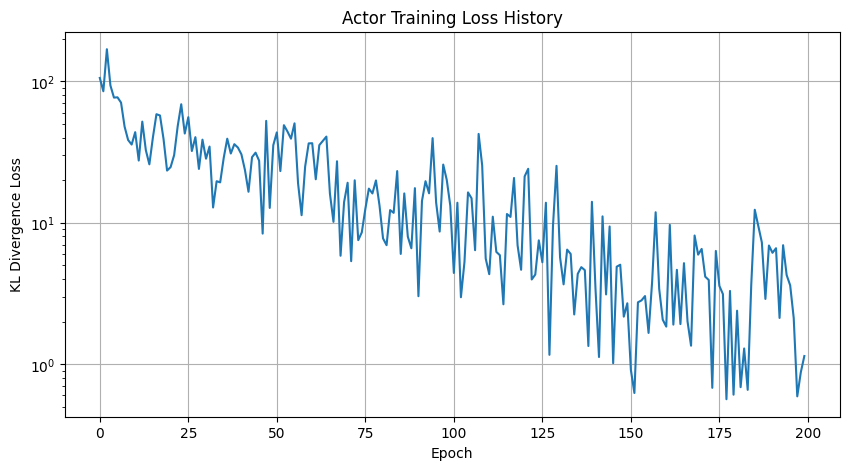

Initial state [2. 2.]:
  Learned policy final cost: 15.11
  Optimal policy final cost: 13.94
  Cost difference: 1.17
Initial state [ 2. -2.]:
  Learned policy final cost: 31.55
  Optimal policy final cost: 31.41
  Cost difference: 0.15
Initial state [-2. -2.]:
  Learned policy final cost: 14.31
  Optimal policy final cost: 14.10
  Cost difference: 0.20
Initial state [-2.  2.]:
  Learned policy final cost: 34.14
  Optimal policy final cost: 34.22
  Cost difference: -0.08


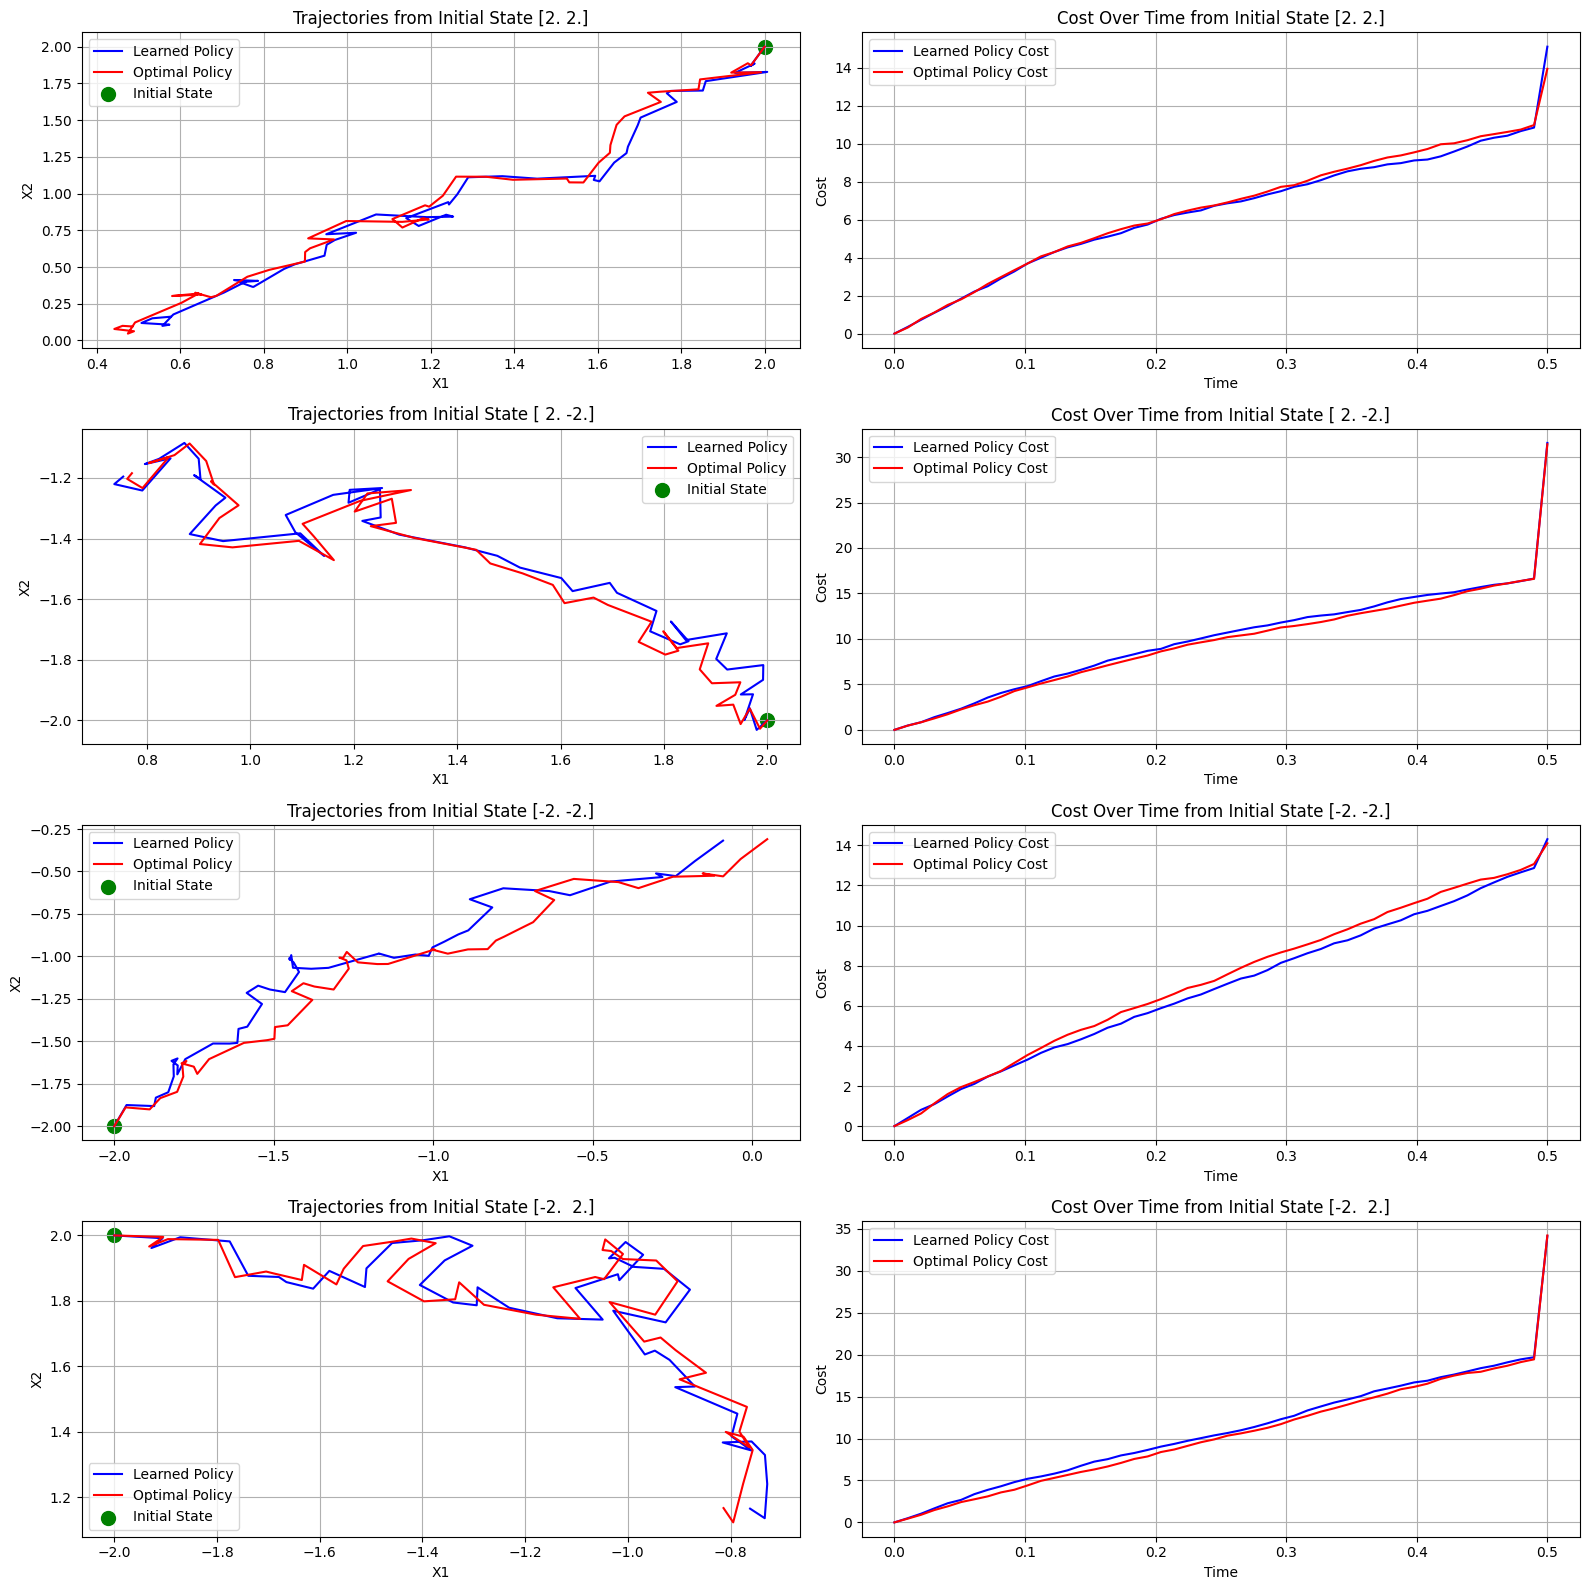

Final mean error: 3.110511e+00
Final covariance error: 1.082165e-02


In [59]:
run_actor_algorithm()

## Question 5

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import time

class ActorCriticAlgorithm:
    """Implementation of the actor-critic algorithm for soft LQR."""
    
    def __init__(self, 
                 soft_lqr: SoftLQR, 
                 actor_hidden_size: int = 256, 
                 critic_hidden_size: int = 512,
                 actor_lr: float = 1e-4,
                 critic_lr: float = 1e-3,
                 device: torch.device = torch.device("cpu")):
        """
        Initialize the actor-critic algorithm.
        
        Args:
            soft_lqr: Instance of SoftLQR class
            actor_hidden_size: Size of hidden layers in the actor network
            critic_hidden_size: Size of hidden layers in the critic network
            actor_lr: Learning rate for actor optimization
            critic_lr: Learning rate for critic optimization
            device: Device to use for computation
        """
        self.soft_lqr = soft_lqr
        self.device = device
        
        # Create actor network (policy)
        self.policy_network = PolicyNN(d=soft_lqr.d, hidden_size=actor_hidden_size, device=device).to(device)
        
        # Create critic network (value function)
        self.value_network = ValueNN(hidden_size=critic_hidden_size, device=device).to(device)
        
        # Ensure all parameters are float64
        for param in self.policy_network.parameters():
            param.data = param.data.to(torch.float64)
        
        for param in self.value_network.parameters():
            param.data = param.data.to(torch.float64)
        
        # Create optimizers
        self.actor_optimizer = optim.Adam(self.policy_network.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.value_network.parameters(), lr=critic_lr)
        
        # MSE loss for critic
        self.critic_criterion = nn.MSELoss()
        
        # For tracking progress
        self.actor_loss_history = []
        self.critic_loss_history = []
    
    def _ensure_float64(self, tensor):
        """Helper method to ensure tensors are consistently float64."""
        if tensor.dtype != torch.float64:
            return tensor.to(torch.float64)
        return tensor
    
    def _generate_batch(self, batch_size: int, state_range: float = 3.0) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate a batch of random states and times for training.
        
        Args:
            batch_size: Number of samples to generate
            state_range: Range for uniform sampling of states
            
        Returns:
            Tuple of (times, states) tensors
        """
        # Sample times uniformly from [0, T]
        times = torch.rand(batch_size, device=self.device, dtype=torch.float64) * self.soft_lqr.T
        
        # Sample states uniformly from [-state_range, state_range]^2
        states = (torch.rand(batch_size, self.soft_lqr.d, device=self.device, dtype=torch.float64) * 2 - 1) * state_range
        
        return times, states
    
    def _compute_target_values(self, t: torch.Tensor, x: torch.Tensor, num_steps: int = 100) -> torch.Tensor:
        """
        Compute target values for critic training by simulating trajectories using the current policy.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            num_steps: Number of time steps for simulation
            
        Returns:
            Target values tensor (batch)
        """
        batch_size = t.shape[0]
        target_values = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        
        for i in range(batch_size):
            # Current time and state
            t_i = t[i].item()
            x_i = x[i:i+1]
            
            # If we're already at terminal time, return terminal cost
            if t_i >= self.soft_lqr.T - 1e-6:
                target_values[i] = torch.matmul(torch.matmul(x_i.squeeze(), self.soft_lqr.R), x_i.squeeze())
                continue
            
            # Determine remaining time and step size
            remaining_time = self.soft_lqr.T - t_i
            dt = remaining_time / num_steps
            
            # Initialize state and cost
            current_state = x_i.clone()
            cost = 0.0
            
            # Simulate trajectory using current policy
            for step in range(num_steps):
                # Current time
                current_time = t_i + step * dt
                current_time_tensor = torch.tensor([current_time], device=self.device, dtype=torch.float64)
                
                # Get control action from current policy
                action = self.policy_network.sample_action(current_time_tensor, current_state)
                
                # Compute running cost
                state_cost = torch.matmul(torch.matmul(current_state.squeeze(), self.soft_lqr.C), current_state.squeeze())
                control_cost = torch.matmul(torch.matmul(action.squeeze(), self.soft_lqr.D), action.squeeze())
                
                # Add entropy regularization term
                _, covariance = self.policy_network.action_distribution(current_time_tensor, current_state)
                covariance = covariance[0] if covariance.dim() > 2 else covariance
                entropy_term = self.soft_lqr.tau * torch.log(torch.det(2 * np.pi * np.e * covariance)) / 2
                
                # Accumulate cost
                cost += (state_cost + control_cost + entropy_term) * dt
                
                # Update state with Euler step
                drift = self.soft_lqr.H @ current_state.squeeze() + self.soft_lqr.M @ action.squeeze()
                noise = self.soft_lqr.sigma @ torch.randn(self.soft_lqr.sigma.shape[1], device=self.device, dtype=torch.float64) * np.sqrt(dt)
                current_state = current_state + (drift * dt + noise).unsqueeze(0)
            
            # Add terminal cost
            terminal_cost = torch.matmul(torch.matmul(current_state.squeeze(), self.soft_lqr.R), current_state.squeeze())
            cost += terminal_cost
            
            target_values[i] = cost
        
        return target_values
    
    def train_critic_step(self, batch_size: int) -> float:
        """
        Perform one training step of the critic algorithm.
        
        Args:
            batch_size: Batch size for training
            
        Returns:
            Loss value from this step
        """
        # Generate batch
        times, states = self._generate_batch(batch_size)
        
        # Compute target values
        with torch.no_grad():
            target_values = self._compute_target_values(times, states)
        
        # Compute predicted values
        predicted_values = self.value_network.value_function(times, states)
        
        # Ensure consistent dtype before computing loss
        predicted_values = self._ensure_float64(predicted_values)
        target_values = self._ensure_float64(target_values)
        
        # Compute loss
        loss = self.critic_criterion(predicted_values, target_values)
        
        # Perform optimization step
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()
        
        return loss.item()
    
    def compute_td_values(self, t: torch.Tensor, x: torch.Tensor, dt: float = 0.05) -> torch.Tensor:
        """
        Compute temporal difference values for actor training.
        
        Args:
            t: Time tensor (batch)
            x: State tensor (batch x d)
            dt: Time step
            
        Returns:
            Temporal difference values (batch)
        """
        batch_size = t.shape[0]
        td_values = torch.zeros(batch_size, device=self.device, dtype=torch.float64)
        
        for i in range(batch_size):
            t_i = t[i].item()
            
            # If at terminal time, use terminal value
            if t_i >= self.soft_lqr.T - 1e-6:
                continue
            
            # Ensure we don't go beyond terminal time
            next_t = min(t_i + dt, self.soft_lqr.T)
            next_t_tensor = torch.tensor([next_t], device=self.device, dtype=torch.float64)
            
            # Current state
            x_i = x[i:i+1]
            current_t_tensor = torch.tensor([t_i], device=self.device, dtype=torch.float64)
            
            # Sample action from current policy
            action = self.policy_network.sample_action(current_t_tensor, x_i)
            
            # Compute current reward
            state_cost = torch.matmul(torch.matmul(x_i.squeeze(), self.soft_lqr.C), x_i.squeeze())
            control_cost = torch.matmul(torch.matmul(action.squeeze(), self.soft_lqr.D), action.squeeze())
            
            # Add entropy regularization term
            _, covariance = self.policy_network.action_distribution(current_t_tensor, x_i)
            covariance = covariance[0] if covariance.dim() > 2 else covariance
            entropy_term = self.soft_lqr.tau * torch.log(torch.det(2 * np.pi * np.e * covariance)) / 2
            
            # Total current reward is negative of cost
            current_reward = -(state_cost + control_cost + entropy_term) * dt
            
            # Compute next state
            drift = self.soft_lqr.H @ x_i.squeeze() + self.soft_lqr.M @ action.squeeze()
            noise = self.soft_lqr.sigma @ torch.randn(self.soft_lqr.sigma.shape[1], device=self.device, dtype=torch.float64) * np.sqrt(dt)
            next_state = x_i + (drift * dt + noise).unsqueeze(0)
            
            # Compute value of next state
            with torch.no_grad():
                next_value = self.value_network.value_function(next_t_tensor, next_state)
            
            # Compute TD value: r + V(s')
            td_values[i] = current_reward + next_value
        
        return td_values
    
    def train_actor_step(self, batch_size: int) -> float:
        """
        Perform one training step of the actor algorithm.
        
        Args:
            batch_size: Batch size for training
            
        Returns:
            Loss value from this step
        """
        # Generate batch
        times, states = self._generate_batch(batch_size)
        
        # Compute TD values for policy gradient
        td_values = self.compute_td_values(times, states)
        
        # Zero gradients
        self.actor_optimizer.zero_grad()
        
        # Compute policy loss
        policy_loss = 0.0
        for i in range(batch_size):
            if times[i].item() >= self.soft_lqr.T - 1e-6:
                continue
                
            # Get action distribution from current policy
            t_i = times[i:i+1]
            x_i = states[i:i+1]
            means, _ = self.policy_network.action_distribution(t_i, x_i)
            
            # Sample action
            action = self.policy_network.sample_action(t_i, x_i)
            
            # Compute log probability of the action
            # For now, we'll use a simplified version based on the mean squared error
            # This is an approximation of the policy gradient
            action_loss = torch.sum((action - means) ** 2)
            
            # Weight by TD value (higher values give stronger gradient)
            policy_loss = policy_loss - action_loss * td_values[i]
        
        # Backward pass and optimization step
        policy_loss.backward()
        self.actor_optimizer.step()
        
        return policy_loss.item()
    
    def train_step(self, batch_size: int) -> Tuple[float, float]:
        """
        Perform one combined actor-critic training step.
        
        Args:
            batch_size: Batch size for training
            
        Returns:
            Tuple of (critic_loss, actor_loss)
        """
        # First update critic (value function)
        critic_loss = self.train_critic_step(batch_size)
        
        # Then update actor (policy)
        actor_loss = self.train_actor_step(batch_size)
        
        return critic_loss, actor_loss
    
    def train(self, num_epochs: int, batch_size: int, eval_interval: int = 10) -> None:
        """
        Train the actor-critic networks.
        
        Args:
            num_epochs: Number of training epochs
            batch_size: Batch size for training
            eval_interval: Interval for evaluation and progress reporting
        """
        print("Starting actor-critic training...")
        start_time = time.time()
        
        for epoch in range(num_epochs):
            critic_loss, actor_loss = self.train_step(batch_size)
            
            self.critic_loss_history.append(critic_loss)
            self.actor_loss_history.append(actor_loss)
            
            if (epoch + 1) % eval_interval == 0 or epoch == 0:
                # Evaluate current performance
                value_error = self.evaluate_value_function()
                policy_error = self.evaluate_policy()
                elapsed = time.time() - start_time
                
                print(f"Epoch {epoch+1}/{num_epochs}, Critic Loss: {critic_loss:.6e}, Actor Loss: {actor_loss:.6e}")
                print(f"Value Error: {value_error:.6e}, Policy Error: {policy_error:.6e}, Time: {elapsed:.2f}s")
        
        print(f"Training completed in {time.time() - start_time:.2f} seconds.")
    
    def evaluate_value_function(self, grid_size: int = 5, state_range: float = 3.0) -> float:
        """
        Evaluate the critic network against the exact value function.
        
        Args:
            grid_size: Number of points in each dimension for evaluation
            state_range: Range for evaluation grid
            
        Returns:
            Maximum absolute error
        """
        # Create evaluation grid
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Time points for evaluation
        time_points = torch.tensor([0, self.soft_lqr.T/3, 2*self.soft_lqr.T/3, self.soft_lqr.T], device=self.device, dtype=torch.float64)
        
        # Store total error
        total_error = 0.0
        count = 0
        
        # Evaluate on grid
        with torch.no_grad():
            for t in time_points:
                t_batch = t.unsqueeze(0)
                for i in range(grid_size):
                    for j in range(grid_size):
                        # Current state
                        x = torch.tensor([[x_grid[i], y_grid[j]]], device=self.device, dtype=torch.float64)
                        
                        # Compute exact and approximate value functions
                        exact_value = self.soft_lqr.value_function(t_batch, x)
                        approx_value = self.value_network.value_function(t_batch, x)
                        
                        # Ensure both are float64
                        exact_value = self._ensure_float64(exact_value)
                        approx_value = self._ensure_float64(approx_value)
                        
                        # Compute error
                        error = torch.abs(exact_value - approx_value).item()
                        total_error += error
                        count += 1
        
        # Return average error
        return total_error / count if count > 0 else 0.0
    
    def evaluate_policy(self, grid_size: int = 5, state_range: float = 3.0) -> float:
        """
        Evaluate the actor network against the exact optimal policy.
        
        Args:
            grid_size: Number of points in each dimension for evaluation
            state_range: Range for evaluation grid
            
        Returns:
            Average error in policy means
        """
        # Create evaluation grid
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Time points for evaluation
        time_points = torch.tensor([0, self.soft_lqr.T/3, 2*self.soft_lqr.T/3, self.soft_lqr.T], device=self.device, dtype=torch.float64)
        
        # Store total error
        total_error = 0.0
        count = 0
        
        # Evaluate on grid
        with torch.no_grad():
            for t in time_points:
                t_batch = t.unsqueeze(0)
                for i in range(grid_size):
                    for j in range(grid_size):
                        # Current state
                        x = torch.tensor([[x_grid[i], y_grid[j]]], device=self.device, dtype=torch.float64)
                        
                        # Compute optimal and learned policy means
                        optimal_means, _ = self.soft_lqr.optimal_control_distribution(t_batch, x)
                        learned_means, _ = self.policy_network.action_distribution(t_batch, x)
                        
                        # Ensure both are float64
                        optimal_means = self._ensure_float64(optimal_means)
                        learned_means = self._ensure_float64(learned_means)
                        
                        # Compute error in means
                        error = torch.norm(optimal_means - learned_means).item()
                        total_error += error
                        count += 1
        
        # Return average error
        return total_error / count if count > 0 else 0.0
    
    def plot_loss_history(self) -> None:
        """Plot the loss history for both actor and critic during training."""
        plt.figure(figsize=(12, 5))
        
        # Plot critic loss
        plt.subplot(1, 2, 1)
        plt.plot(self.critic_loss_history)
        plt.yscale('log')
        plt.xlabel('Epoch')
        plt.ylabel('Critic Loss')
        plt.title('Critic Training Loss History')
        plt.grid(True)
        
        # Plot actor loss
        plt.subplot(1, 2, 2)
        plt.plot(self.actor_loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Actor Loss')
        plt.title('Actor Training Loss History')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_value_function_comparison(self, grid_size: int = 20, state_range: float = 3.0) -> None:
        """
        Plot comparison between exact and learned value function.
        
        Args:
            grid_size: Number of points in each dimension for plotting
            state_range: Range for plotting grid
        """
        # Create evaluation grid
        x_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        y_grid = torch.linspace(-state_range, state_range, grid_size, device=self.device, dtype=torch.float64)
        
        # Evaluation time (t=0)
        t = torch.tensor([0.0], device=self.device, dtype=torch.float64)
        
        # Initialize arrays for values
        X, Y = np.meshgrid(x_grid.cpu().numpy(), y_grid.cpu().numpy())
        exact_values = np.zeros((grid_size, grid_size))
        approx_values = np.zeros((grid_size, grid_size))
        errors = np.zeros((grid_size, grid_size))
        
        # Compute values on grid
        with torch.no_grad():
            for i in range(grid_size):
                for j in range(grid_size):
                    # Current state
                    x = torch.tensor([[x_grid[i].item(), y_grid[j].item()]], device=self.device, dtype=torch.float64)
                    
                    # Compute exact and approximate value functions
                    exact_value = self.soft_lqr.value_function(t, x).item()
                    approx_value = self.value_network.value_function(t, x).item()
                    
                    # Store values
                    exact_values[j, i] = exact_value
                    approx_values[j, i] = approx_value
                    errors[j, i] = np.abs(exact_value - approx_value)
        
        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Plot exact value function
        im1 = axes[0].contourf(X, Y, exact_values, 50, cmap='viridis')
        axes[0].set_title('Exact Value Function at t=0')
        axes[0].set_xlabel('x1')
        axes[0].set_ylabel('x2')
        plt.colorbar(im1, ax=axes[0])
        
        # Plot approximate value function
        im2 = axes[1].contourf(X, Y, approx_values, 50, cmap='viridis')
        axes[1].set_title('Learned Value Function at t=0')
        axes[1].set_xlabel('x1')
        axes[1].set_ylabel('x2')
        plt.colorbar(im2, ax=axes[1])
        
        # Plot error
        im3 = axes[2].contourf(X, Y, errors, 50, cmap='hot')
        axes[2].set_title('Absolute Error')
        axes[2].set_xlabel('x1')
        axes[2].set_ylabel('x2')
        plt.colorbar(im3, ax=axes[2])
        
        plt.tight_layout()
        plt.show()
    
    def compare_policies(self, test_states: List[List[float]], dt: float = 0.01) -> None:
        """
        Compare trajectories using the learned policy versus the optimal policy.
        
        Args:
            test_states: List of initial states to test
            dt: Time step for simulation
        """
        # Convert test states to tensors
        num_states = len(test_states)
        test_states_tensor = torch.tensor(test_states, device=self.device, dtype=torch.float64)
        
        # Time points for simulation
        num_steps = int(self.soft_lqr.T / dt)
        time_points = torch.linspace(0, self.soft_lqr.T, num_steps, device=self.device, dtype=torch.float64)
        
        # Initialize plot
        fig, axes = plt.subplots(num_states, 2, figsize=(16, 4*num_states))
        if num_states == 1:
            axes = axes.reshape(1, 2)
        
        # Simulate for each initial state
        for i, x0 in enumerate(test_states_tensor):
            x0 = x0.view(1, -1)  # Add batch dimension
            
            # Initialize state trajectories
            learned_traj = torch.zeros((num_steps, self.soft_lqr.d), device=self.device, dtype=torch.float64)
            optimal_traj = torch.zeros((num_steps, self.soft_lqr.d), device=self.device, dtype=torch.float64)
            learned_traj[0] = x0
            optimal_traj[0] = x0
            
            # Accumulated costs
            learned_costs = torch.zeros(num_steps, device=self.device, dtype=torch.float64)
            optimal_costs = torch.zeros(num_steps, device=self.device, dtype=torch.float64)
            
            # Generate same noise for both simulations
            noise_seq = torch.randn((num_steps, self.soft_lqr.sigma.shape[1]), 
                                    device=self.device, dtype=torch.float64) * np.sqrt(dt)
            
            # Simulate trajectories
            for n in range(1, num_steps):
                t_n = time_points[n-1]
                t_tensor = t_n.unsqueeze(0)
                
                # Learned policy step
                learned_control = self.policy_network.sample_action(t_tensor, learned_traj[n-1:n])
                learned_drift = self.soft_lqr.H @ learned_traj[n-1] + self.soft_lqr.M @ learned_control[0]
                learned_traj[n] = learned_traj[n-1] + learned_drift * dt + self.soft_lqr.sigma @ noise_seq[n-1]
                
                # Optimal policy step
                optimal_control = self.soft_lqr.optimal_control(t_tensor, optimal_traj[n-1:n])
                optimal_drift = self.soft_lqr.H @ optimal_traj[n-1] + self.soft_lqr.M @ optimal_control[0]
                optimal_traj[n] = optimal_traj[n-1] + optimal_drift * dt + self.soft_lqr.sigma @ noise_seq[n-1]
                
                # Compute running costs
                learned_state_cost = learned_traj[n-1] @ self.soft_lqr.C @ learned_traj[n-1]
                learned_control_cost = learned_control[0] @ self.soft_lqr.D @ learned_control[0]
                learned_costs[n] = learned_costs[n-1] + (learned_state_cost + learned_control_cost) * dt
                
                optimal_state_cost = optimal_traj[n-1] @ self.soft_lqr.C @ optimal_traj[n-1]
                optimal_control_cost = optimal_control[0] @ self.soft_lqr.D @ optimal_control[0]
                optimal_costs[n] = optimal_costs[n-1] + (optimal_state_cost + optimal_control_cost) * dt
            
            # Add terminal costs
            learned_terminal = learned_traj[-1] @ self.soft_lqr.R @ learned_traj[-1]
            optimal_terminal = optimal_traj[-1] @ self.soft_lqr.R @ optimal_traj[-1]
            learned_costs[-1] += learned_terminal
            optimal_costs[-1] += optimal_terminal
            
            # Plot trajectory
            ax1 = axes[i, 0]
            ax1.plot(learned_traj.cpu().detach().numpy()[:, 0], learned_traj.cpu().detach().numpy()[:, 1], 'b-', label='Learned Policy')
            ax1.plot(optimal_traj.cpu().detach().numpy()[:, 0], optimal_traj.cpu().detach().numpy()[:, 1], 'r-', label='Optimal Policy')
            ax1.scatter([x0[0, 0].item()], [x0[0, 1].item()], color='g', s=100, marker='o', label='Initial State')
            ax1.set_title(f'Trajectories from Initial State {x0.squeeze().cpu().numpy()}')
            ax1.set_xlabel('X1')
            ax1.set_ylabel('X2')
            ax1.grid(True)
            ax1.legend()
            
            # Plot costs
            ax2 = axes[i, 1]
            ax2.plot(time_points.cpu().detach().numpy(), learned_costs.cpu().detach().numpy(), 'b-', label='Learned Policy Cost')
            ax2.plot(time_points.cpu().detach().numpy(), optimal_costs.cpu().detach().numpy(), 'r-', label='Optimal Policy Cost')
            ax2.set_title(f'Cost Over Time from Initial State {x0.squeeze().cpu().numpy()}')
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Cost')
            ax2.grid(True)
            ax2.legend()
            
            print(f"Initial state {x0.squeeze().cpu().detach().numpy()}:")
            print(f"  Learned policy final cost: {learned_costs[-1].item():.2f}")
            print(f"  Optimal policy final cost: {optimal_costs[-1].item():.2f}")
            print(f"  Cost difference: {(learned_costs[-1] - optimal_costs[-1]).item():.2f}")
        
        plt.tight_layout()
        plt.show()


def run_actor_critic_algorithm():
    """Run the actor-critic algorithm for soft LQR."""
    # Set the problem matrices as specified in assignment
    H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64) * 0.5
    M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float64)
    sigma = torch.eye(2, dtype=torch.float64) * 0.5
    C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float64) * 1.0
    
    # Use identity matrix for D as specified in the hints
    D = torch.eye(2, dtype=torch.float64) 
    
    R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float64) * 10.0
    
    # Set parameters as specified in the hints
    T = 0.5
    tau = 0.5
    gamma = 1.0
    
    # Create time grid
    grid_size = 1000
    time_grid = torch.linspace(0, T, grid_size, dtype=torch.float64)
    
    # Create soft LQR instance and solve Ricatti ODE
    soft_lqr = SoftLQR(H, M, sigma, C, D, R, T, time_grid, tau, gamma)
    soft_lqr.solve_ricatti()
    
    # Create actor-critic algorithm
    actor_critic = ActorCriticAlgorithm(
        soft_lqr, 
        actor_hidden_size=256, 
        critic_hidden_size=512, 
        actor_lr=1e-4, 
        critic_lr=1e-3
    )
    
    # Train actor-critic
    actor_critic.train(num_epochs=300, batch_size=64, eval_interval=20)
    
    # Plot results
    actor_critic.plot_loss_history()
    actor_critic.plot_value_function_comparison()
    
    # Compare policies on test states
    test_states = [
        [2.0, 2.0],
        [2.0, -2.0],
        [-2.0, -2.0],
        [-2.0, 2.0]
    ]
    actor_critic.compare_policies(test_states)
    
    # Evaluate final performance
    value_error = actor_critic.evaluate_value_function(grid_size=10)
    policy_error = actor_critic.evaluate_policy(grid_size=10)
    print(f"Final value function error: {value_error:.6e}")
    print(f"Final policy error: {policy_error:.6e}")
    
    return actor_critic

In [ ]:
run_actor_critic_algorithm()

Starting actor-critic training...
Epoch 1/300, Critic Loss: 1.257577e+04, Actor Loss: -9.994707e+00
Value Error: 4.579942e+01, Policy Error: 1.312613e+01, Time: 10.74s
Epoch 20/300, Critic Loss: 1.659237e+03, Actor Loss: -3.523306e+03
Value Error: 7.202059e+01, Policy Error: 1.307502e+01, Time: 192.42s
Epoch 40/300, Critic Loss: 6.041036e+02, Actor Loss: -2.133840e+04
Value Error: 8.712706e+01, Policy Error: 1.307799e+01, Time: 442.13s
Epoch 60/300, Critic Loss: 4.214246e+02, Actor Loss: -4.133740e+04
Value Error: 9.338484e+01, Policy Error: 1.302250e+01, Time: 680.02s
Epoch 80/300, Critic Loss: 7.045117e+02, Actor Loss: -1.039892e+05
Value Error: 8.661764e+01, Policy Error: 1.308054e+01, Time: 877.97s
Epoch 100/300, Critic Loss: 8.094126e+02, Actor Loss: -2.824313e+05
Value Error: 1.131110e+02, Policy Error: 1.330047e+01, Time: 1075.22s
